
# 导入包

In [1]:
#  基础数据科学运算库
import pandas as pd
import numpy as np
import math
from scipy import stats

# 可视化库
import seaborn as sns
import matplotlib.pyplot as plt
# 排列组合函数
from itertools import product 
# 时间模块
import time
# sklearn库
# 数据预处理
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split,cross_val_predict,cross_validate,cross_val_score,KFold,LeaveOneOut
from sklearn import metrics
# 常用评估器
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

# 常用的特征选择方法
import pymrmr
from minepy import MINE
import shap
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
import dcor

#忽略警告
import warnings
warnings.filterwarnings('ignore')


D:\Anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# 导入数据

In [2]:
data=pd.read_csv('mix-halide-perovskite-ml-bandgap.csv')# github上数据为：perovskites.csv
data_=data.iloc[:,2:]
X=data_.iloc[:,1:]
y=data_.iloc[:,0]

# 定义函数

## 分层抽样函数

In [3]:
def stratifed_sample_cut(df,Y_columns,features,groups,train_split_ratio,random_state=None):
    """df:数据集
    Y_columns：目标变量
    features:特征集合
    groups：拆分组数
    train_split_ratio：训练集合百分比
    返回标准化后的X_train X_test y_train y_test
    """
    df_train = pd.DataFrame()
    ratio = train_split_ratio
    groups_list = [f'G{i}' for i in range(1,groups+1)] # G1 G2 ……
    df['groups'] = pd.cut(df[Y_columns], groups, labels=groups_list)
    for i in groups_list:
        df_group = df[df.groups == i] # 其中一个Group
        count = len(df_group)
        train_number  = round(count*ratio)
        print(train_number)
        df_train = df_train.append(df_group.sample(train_number,random_state=random_state))#  pandas.DataFrame.sample 随机选取若干行
       
    # test index 
    df_test_index = list(set(df.index)-set(df_train.index))
    # test_df 
    df_test = df[df.index.isin(df_test_index)]
    X_train = df_train[features]
    y_train = df_train[Y_columns].values.astype(float)
    X_test = df_test[features]
    y_test = df_test[Y_columns].values.astype(float)
    
    #标准化
    scaler = StandardScaler().fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train),columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test),columns=X_train.columns)
    return X_train,X_test,y_train,y_test

## 定义阈值

In [4]:
# 结果四舍五入  round
FN=len(X.columns)# 特征总数
def geometric_mean(data):  # 计算几何平均数
    total=1
    for i in data:
        total*=i #等同于total=total*i
    return round(pow(total,1/len(data)))

thr_geo=geometric_mean([*range(1,FN+1)])# 几何平均值 1,2……，n

def thr_log2n(data):
    thr_logn=round(math.log(data,2))#四舍五入
    return thr_logn
thr_logn=thr_log2n(FN)

thr_25=round(FN*0.25)
thr_50=round(FN*0.5)
thresholds_name=['thr_geo','thr_logn','25%','50%']
thresholds=[thr_geo,thr_logn,thr_25,thr_50]

print(thresholds)


[28, 6, 18, 36]


## 计算最大信息系数

In [11]:
# 小数位数 4→6
def mic_xy(X_train,y_train):# 计算特征与目标变量的最大信息系数，未排序 特征 mic得分一一对应
    MIC_score=[]
    for i in X_train.columns:
        x_=X_train[i]
        mine = MINE(alpha=0.6, c=15)
        mine.compute_score(x_, y_train)
        mic = np.around(mine.mic(),6)# 保留六位小数
        MIC_score.append(mic)
    MIC_score= pd.DataFrame(list(zip(X_train.columns,MIC_score)),columns=['Feature_MIC','Score_MIC'])
    return MIC_score

# total train test 分布可视化

146
50
38
26
55
66
29
14
5
4


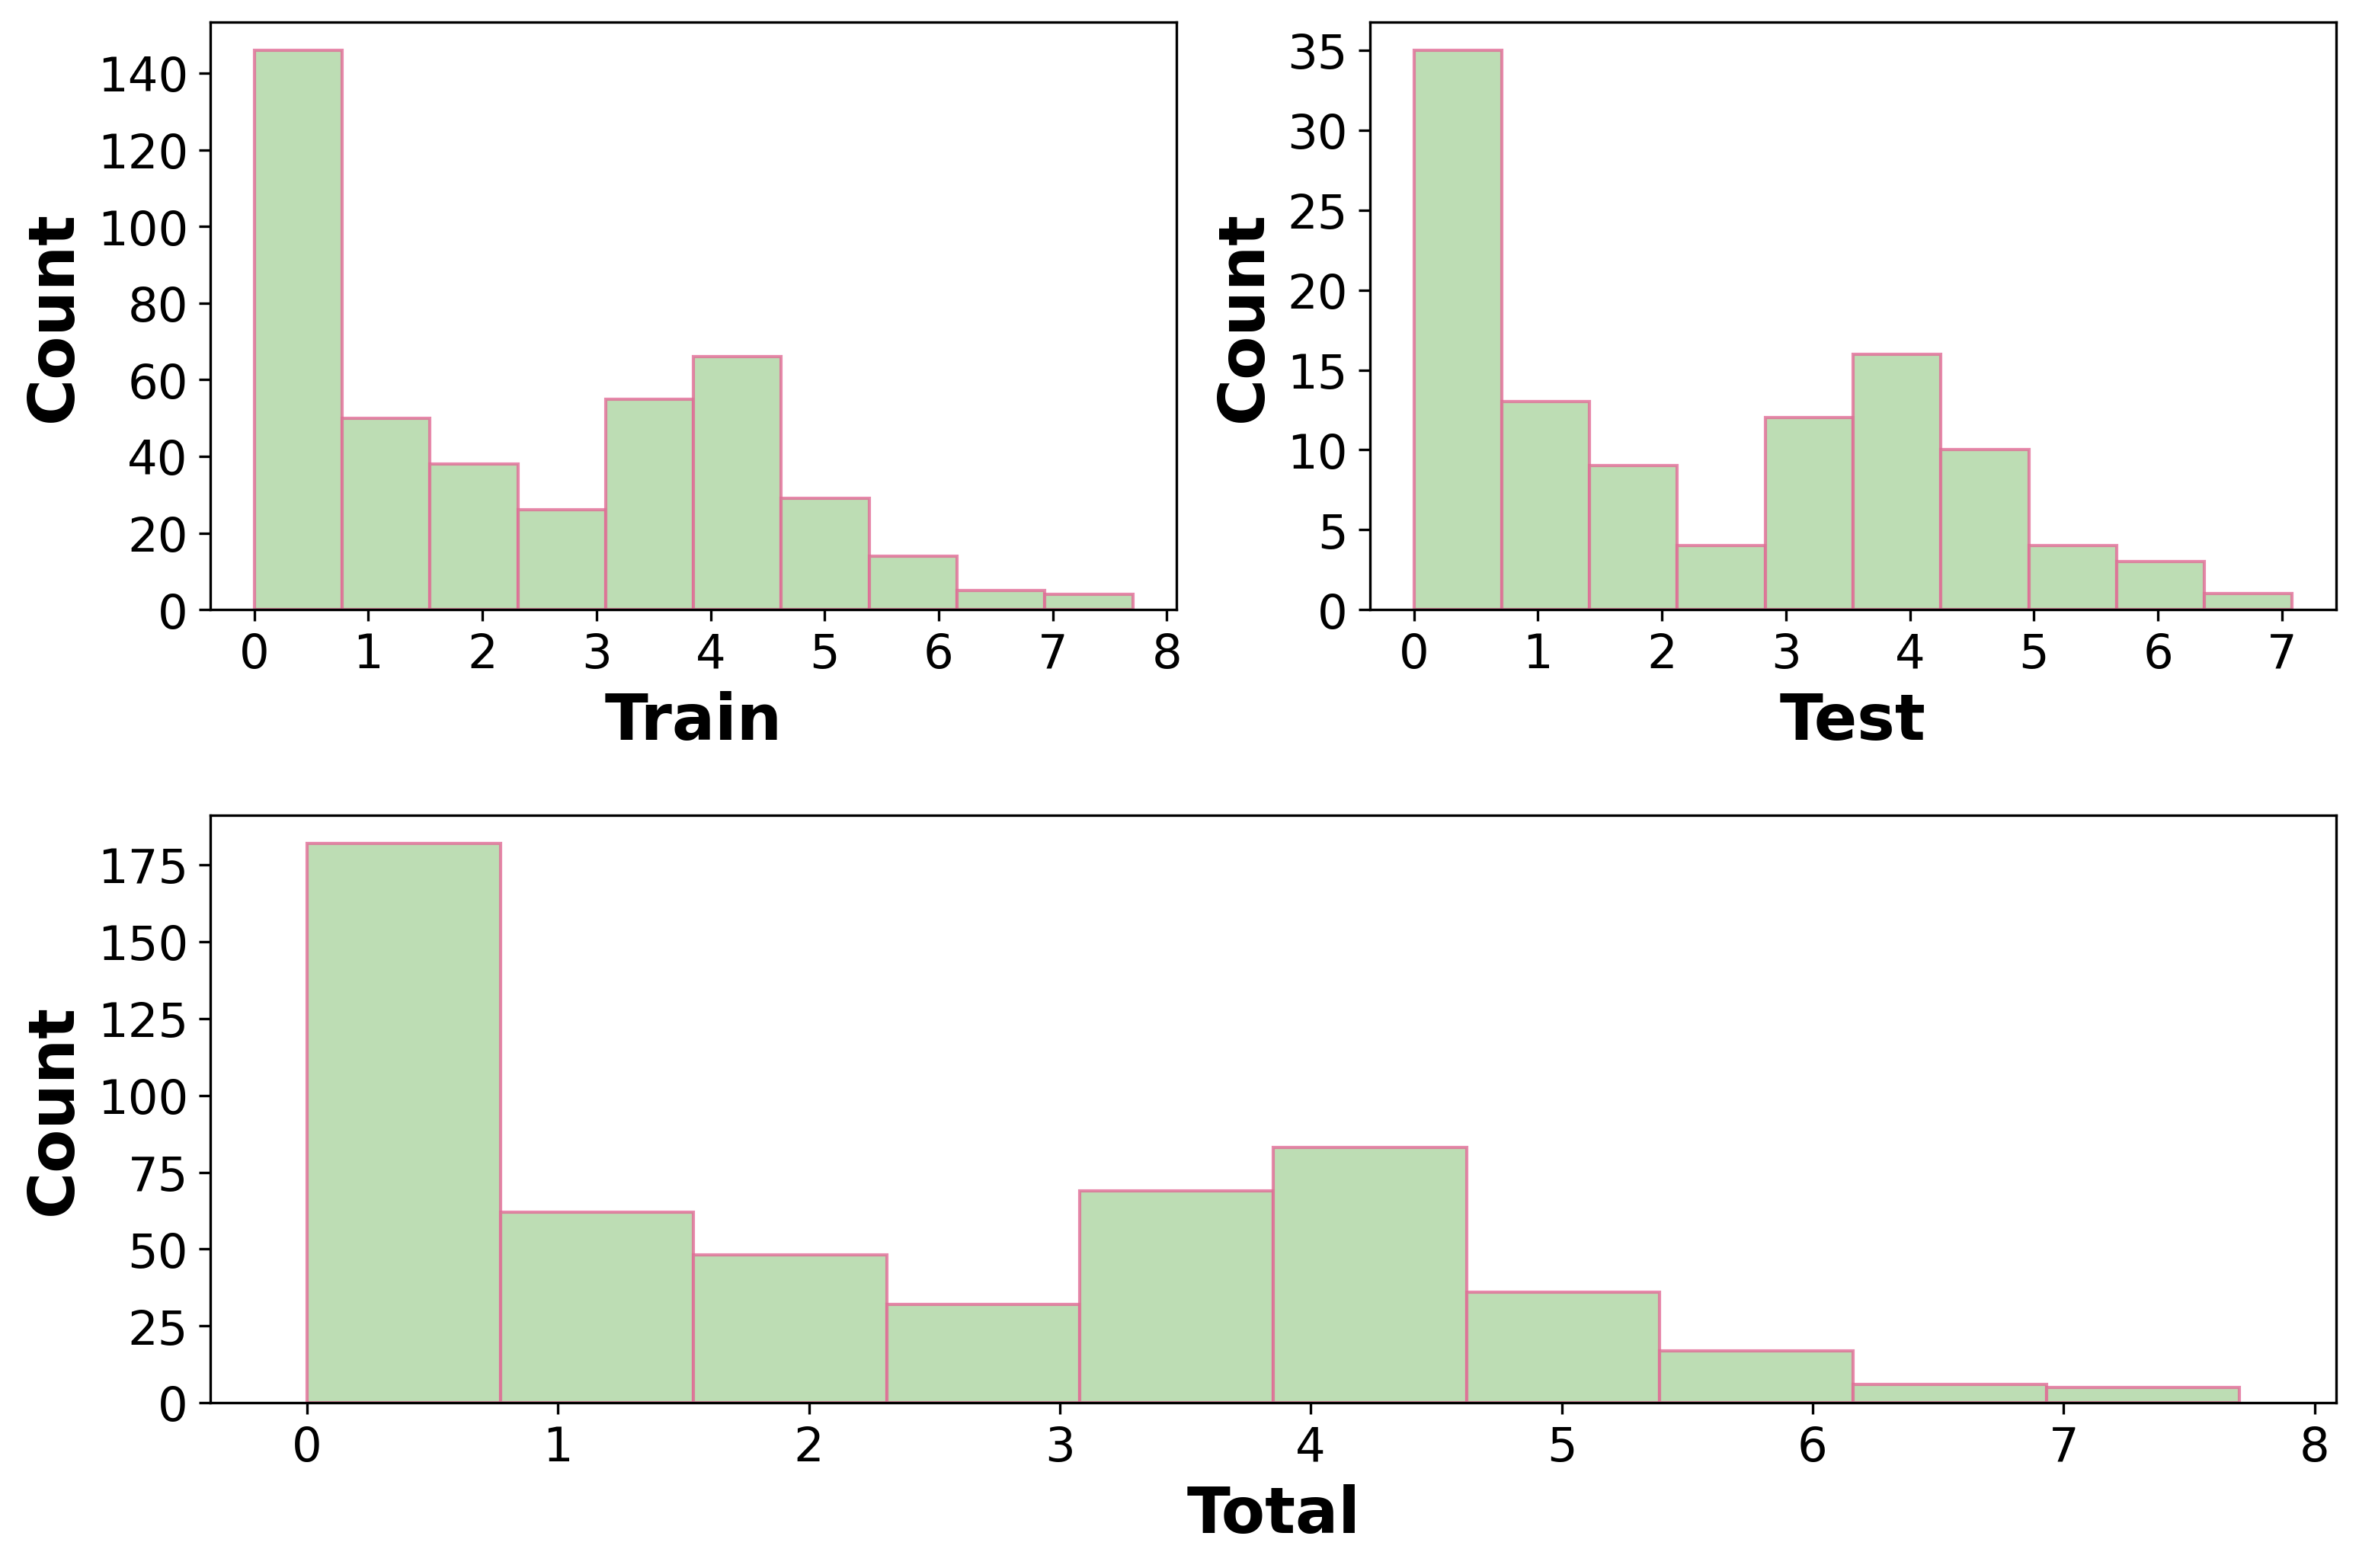

In [12]:
data=pd.read_csv('mix-halide-perovskite-ml-bandgap.csv')
data_=data.iloc[:,2:]
X=data_.iloc[:,1:]
y=data_.iloc[:,0]

num_bins = round(1 + np.log2(data_.shape[0]))# 向下取整修改为四舍五入
features=data_.columns[1:]
target=data_.columns[0]
X_train,X_test,y_train,y_test= stratifed_sample_cut(data_,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)

plt.figure(figsize=(12, 8),dpi=300)

plt.subplot(2,1,2)
plt.hist(y,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8)# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('Total',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小


plt.subplot(2,2,1)
plt.hist(y_train,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8)# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('Train',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小

plt.subplot(2,2,2)
plt.hist(y_test,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8)# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('Test',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小

# 调整子图间距
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)

146
50
38
26
55
66
29
14
5
4


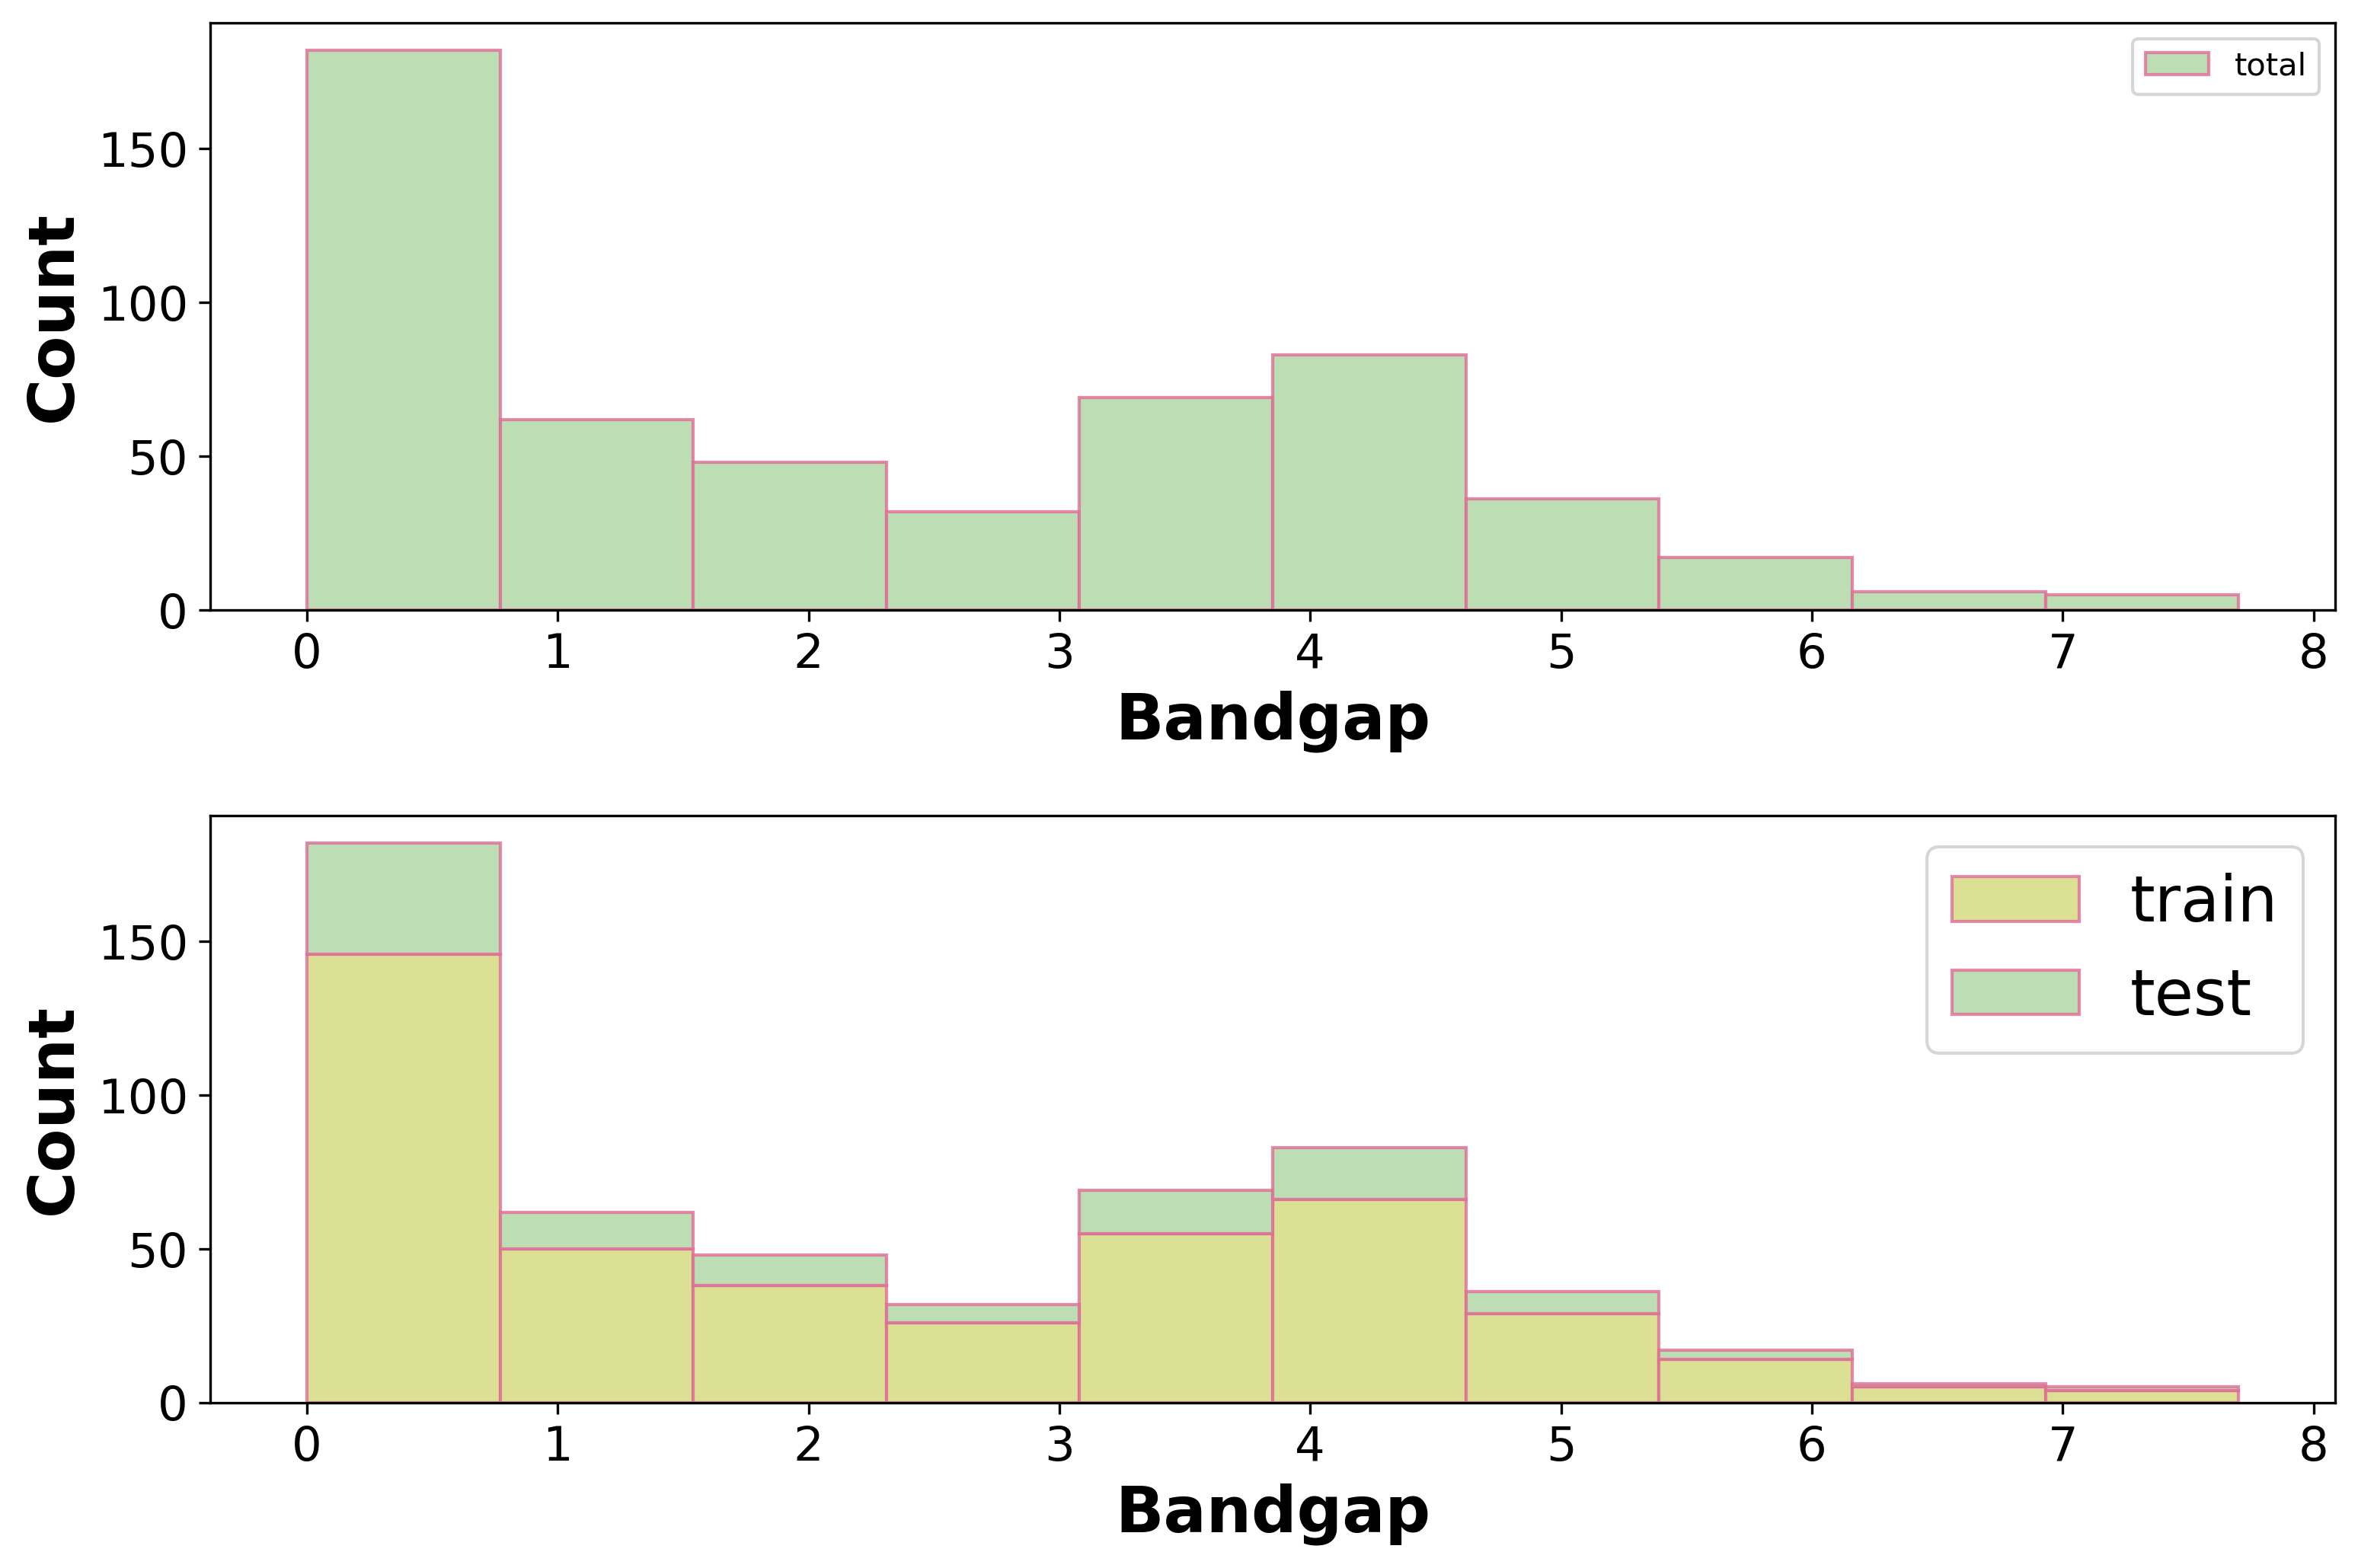

In [14]:
# 堆叠直方图
data=pd.read_csv('mix-halide-perovskite-ml-bandgap.csv')
data_=data.iloc[:,2:]
X=data_.iloc[:,1:]
y=data_.iloc[:,0]
num_bins = round(1 + np.log2(data_.shape[0]))# 向下取整修改为四舍五入
features=data_.columns[1:]
target=data_.columns[0]
X_train,X_test,y_train,y_test= stratifed_sample_cut(data_,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)

plt.figure(figsize=(12, 8),dpi=300)
plt.subplot(2,1,1)
plt.hist(y,bins=num_bins,edgecolor="#e16c96",histtype="bar",color='#add5a2',alpha=0.8,label='total')# #5d655f郎烟灰 #add5a2嘉陵水绿 
plt.xlabel('Bandgap',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='upper right') 

plt.subplot(2,1,2)
plt.hist([y_train,y_test],bins=num_bins,edgecolor="#e16c96",color=["#d2d97a","#add5a2"],alpha=0.8,stacked=True,label=["train","test"])
plt.xlabel('Bandgap',fontsize=20, fontweight='bold') #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('Count',fontsize=20, fontweight='bold') #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.rcParams.update({'font.size': 20})    
plt.legend(loc='upper right') 


# 调整子图间距
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35)



# MIC—SHAP

In [16]:
np.log2(data_.shape[0])

9.076815597050832

In [17]:
math.log(data_.shape[0],2)

9.076815597050832

In [19]:
# random_state=0
data=pd.read_csv('mix-halide-perovskite-ml-bandgap.csv')
data_=data.iloc[:,2:]
X=data_.iloc[:,1:]
y=data_.iloc[:,0]
num_bins = round(1 + np.log2(data_.shape[0]))# 向下取整修改为四舍五入
features=data_.columns[1:]
target=data_.columns[0]
X_train,X_test,y_train,y_test= stratifed_sample_cut(data_,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)

146
50
38
26
55
66
29
14
5
4


## 计算SHAP values¶

In [31]:
#SVR MLP默认参数改一下
# KNeighborsRegressor() 默认时报错   'NoneType' object has no attribute 'split'
models=[LinearRegression(),Ridge(),KNeighborsRegressor(algorithm='kd_tree'),SVR(),MLPRegressor(random_state=0),XGBRegressor(random_state=0),RandomForestRegressor(random_state=0),CatBoostRegressor(verbose=False,random_state=0)]
modelname=['Linear','Ridge','KNN','SVR','MLP','XGBoost','RF','CatBoost']
import shap
score_shap_model_cut_0=pd.DataFrame([])
MIC_score=mic_xy(X_train,y_train)
for name,model in zip(modelname,models):
    print("="*60)
    print(name)
    model=model   #建立模型
    model.fit(X_train,y_train)
    explainer = shap.explainers.Permutation(model.predict, X_train)
    shap_values = explainer(X_train)
    #shap.summary_plot(shap_values, x, plot_type="bar",color='green')
    SHAP_score=pd.DataFrame(shap_values.values).apply(lambda x:abs(x)).mean()
    SHAP_score=round(pd.DataFrame(SHAP_score),6)
    score_shap_model_cut_0[name]=SHAP_score
score_shap_model_cut_0

Linear


Permutation explainer: 434it [00:32,  9.65it/s]                                                                        


Ridge


Permutation explainer: 434it [00:29,  9.54it/s]                                                                        


KNN


Permutation explainer: 434it [30:29,  4.24s/it]                                                                        


SVR


Permutation explainer: 434it [24:09,  3.37s/it]                                                                        


MLP


Permutation explainer: 434it [01:21,  4.68it/s]                                                                        


XGBoost


Permutation explainer: 434it [00:54,  6.50it/s]                                                                        


RF


Permutation explainer: 434it [04:01,  1.72it/s]                                                                        


CatBoost


Permutation explainer: 434it [01:08,  5.36it/s]                                                                        


,Linear,Ridge,KNN,SVR,MLP,XGBoost,RF,CatBoost
0,1.623582e+10,0.035550,0.010290,0.007222,0.050736,0.018236,0.001443,0.008148
1,1.224010e+10,0.382307,0.039706,0.057915,0.176431,0.025040,0.009879,0.045057
2,3.571754e+06,0.053004,0.021782,0.020667,0.065154,0.009928,0.002352,0.006932
3,9.788123e+11,0.047782,0.010578,0.007169,0.048772,0.000001,0.001853,0.005038
4,2.299370e+10,0.361564,0.031901,0.024991,0.066755,0.000044,0.001035,0.031027
...,...,...,...,...,...,...,...,...
67,1.945547e+01,0.152548,0.014159,0.014078,0.079945,0.000492,0.002014,0.006189
68,2.592945e+01,0.095419,0.006146,0.005003,0.137731,0.000001,0.001807,0.011208
69,1.977560e+01,0.102793,0.007692,0.005577,0.072409,0.000078,0.004695,0.014294
70,1.012496e+01,0.138104,0.005545,0.004715,0.070118,0.000033,0.001203,0.002174


In [32]:
score_shap_model_cut_0['MIC']=MIC_score['Score_MIC']
score_shap_model_cut_0=pd.DataFrame(MinMaxScaler().fit_transform(score_shap_model_cut_0),columns=modelname+['MIC'])
score_shap_model_cut_0.to_csv('20221026score_shap_model_cut_0.csv')

In [10]:
score_shap_model_cut_0=pd.read_csv('20221026score_shap_model_cut_0.csv')

In [33]:
#阈值
FN=len(X_train.columns)
thr_geo=geometric_mean([*range(1,FN+1)])
thr_logn=thr_log2n(FN)
thr_25=round(FN*0.25)
thr_50=round(FN*0.5)
thresholds_name=['thr_geo','thr_logn','25%','50%']
thresholds=[thr_geo,thr_logn,thr_25,thr_50]
thresholds

[28, 6, 18, 36]

## 定义不同阈值下权重优化函数

### 几何平均值

In [36]:
# 几何平均值
thr=thr_geo
thr_name='thr_geo'
print(thr)
cv5_score_sum_geo,cv10_score_sum_geo,test_score_sum_geo= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_geo,cv10_score_sum_geo,test_score_sum_geo

28
Linear
test_r2: [0.965619, 0.965619, 0.965619, 0.965619, 0.964499, 0.964499, 0.9602, 0.960358, 0.960579, 0.960589, 0.896167]
test_r:  [0.982952, 0.982952, 0.982952, 0.982952, 0.982503, 0.982503, 0.980053, 0.980138, 0.980225, 0.980229, 0.94693]
test_rmse:  [0.350498, 0.350498, 0.350498, 0.350498, 0.356161, 0.356161, 0.37711, 0.376359, 0.375311, 0.375262, 0.609106]
0.965619 0
test_a_best = 0.0
test_b_best= 1.0
cv5_r :  [0.98477, 0.98477, 0.98477, 0.98477, 0.984714, 0.984714, 0.982597, 0.982611, 0.981587, 0.981617, 0.942943]
cv5_r2 :  [0.969771, 0.969771, 0.969771, 0.969771, 0.969661, 0.969661, 0.965495, 0.965523, 0.963512, 0.963572, 0.889115]
0.969771 0
a_best_cv5 = 0.0
b_best_cv5= 1.0
features_cv5= ['(B_ea/B_r_ion)/(X_ea/X_r_ion)', '(B_ea / X_ea)/(B_r_ion + X_r_ion)', '(B_x / X_x)', '(B_ea / X_ea)', '(B_x / X_x)/(B_r_ion + X_r_ion)', '(B_x/B_r_ion)/(X_x/X_r_ion)', 'ratio_X_bx_bond_mean', '(B_x/B_r_ion)', 'B_x', '(B_x - X_x)', '(B_ea/B_r_ion)*(X_ea/X_r_ion)', 'ratio_ea_bx_bond_mean', 

test_r2: [0.976242, 0.97257, 0.9756, 0.975102, 0.97628, 0.976347, 0.976725, 0.980239, 0.983324, 0.980575, 0.980952]
test_r:  [0.988211, 0.986457, 0.987895, 0.987561, 0.988099, 0.988374, 0.98848, 0.990287, 0.991701, 0.990347, 0.990503]
test_rmse:  [0.291363, 0.31307, 0.295274, 0.298271, 0.291127, 0.290717, 0.288383, 0.265725, 0.2441, 0.263452, 0.260887]
0.983324 8
test_a_best = 0.8
test_b_best= 0.19999999999999996
cv5_r :  [0.989143, 0.987994, 0.988467, 0.988824, 0.988406, 0.988927, 0.989428, 0.989617, 0.989649, 0.989703, 0.990132]
cv5_r2 :  [0.978403, 0.976131, 0.97706, 0.977772, 0.976946, 0.977977, 0.978968, 0.97934, 0.979404, 0.97951, 0.980362]
0.980362 10
a_best_cv5 = 1.0
b_best_cv5= 0.0
features_cv5= ['B_M', 'ratio_ea_bx_bond_mean', 'gap_AO', 'delta_ea_bx_bond_mean', 'B_N', 'B_r_atom', '(B_x / X_x)', 'LUMO', 'log(delta_X_bx_bond_cv)', 'B_ie', '(A_r_ion + X_r_ion)/(1.414*(B_r_ion + X_r_ion))', '(B_r_ion / X_r_ion)', 'B_x', '(B_ea / X_ea)', 'delta_X_bx_bond_cv', '(B_x/B_r_ion)-(X_x/X

(         FN=28  Linearthr_geo_cv5  Ridgethr_geo_cv5  KNNthr_geo_cv5  \
 0   a_best_cv5           0.000000          1.000000        0.900000   
 1   cv5_r_best           0.984770          0.984536        0.985922   
 2  cv5_r2_best           0.969771          0.969207        0.971857   
 3   test_r_cv5           0.982952          0.984138        0.986207   
 4  test_r2_cv5           0.965619          0.968447        0.972364   
 
    SVRthr_geo_cv5  MLPthr_geo_cv5  XGBoostthr_geo_cv5  RFthr_geo_cv5  \
 0        0.900000        1.000000            1.000000       1.000000   
 1        0.990455        0.990132            0.993209       0.990837   
 2        0.980619        0.980362            0.986454       0.981681   
 3        0.990967        0.990503            0.993227       0.992185   
 4        0.981816        0.980952            0.986485       0.984427   
 
    CatBoostthr_geo_cv5  
 0             1.000000  
 1             0.995000  
 2             0.989982  
 3             0.99575

In [43]:
# 验证
data=pd.read_csv('mix-halide-perovskite-ml-bandgap.csv')
data_=data.iloc[:,2:]
X=data_.iloc[:,1:]
y=data_.iloc[:,0]
num_bins = round(1 + np.log2(data_.shape[0]))# 向下取整修改为四舍五入
features=data_.columns[1:]
target=data_.columns[0]
X_train,X_test,y_train,y_test= stratifed_sample_cut(data_,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)
x_train=X_train[['(B_x / X_x)', 'B_x', 'ratio_X_bx_bond_mean', '(B_x/B_r_ion)/(X_x/X_r_ion)', '(B_x/B_r_ion)', '(B_x - X_x)', '(B_x / X_x)/(B_r_ion + X_r_ion)', 'ratio_ea_bx_bond_mean', '(B_ea/B_r_ion)-(X_ea/X_r_ion)', 'B_r_atom', 'LUMO', '(B_x/B_r_ion)-(X_x/X_r_ion)', 'X_r_ion', '(B_x - X_x)/(B_r_ion + X_r_ion)', '(B_r_ion / X_r_ion)', 'B_r_ion', '(B_ea/B_r_ion)/(X_ea/X_r_ion)', '(X_ea/X_r_ion)', 'X_M', '(B_ea - X_ea)', 'gap_AO', '(A_r_ion + X_r_ion)/(1.414*(B_r_ion + X_r_ion))', 'B_M', '(B_ea - X_ea)/(B_r_ion + X_r_ion)', 'ratio_X_bx_bond_cv', 'X_ea', '(B_ea/B_r_ion)', '(B_ea / X_ea)/(B_r_ion + X_r_ion)']]
x_test=X_test[['(B_x / X_x)', 'B_x', 'ratio_X_bx_bond_mean', '(B_x/B_r_ion)/(X_x/X_r_ion)', '(B_x/B_r_ion)', '(B_x - X_x)', '(B_x / X_x)/(B_r_ion + X_r_ion)', 'ratio_ea_bx_bond_mean', '(B_ea/B_r_ion)-(X_ea/X_r_ion)', 'B_r_atom', 'LUMO', '(B_x/B_r_ion)-(X_x/X_r_ion)', 'X_r_ion', '(B_x - X_x)/(B_r_ion + X_r_ion)', '(B_r_ion / X_r_ion)', 'B_r_ion', '(B_ea/B_r_ion)/(X_ea/X_r_ion)', '(X_ea/X_r_ion)', 'X_M', '(B_ea - X_ea)', 'gap_AO', '(A_r_ion + X_r_ion)/(1.414*(B_r_ion + X_r_ion))', 'B_M', '(B_ea - X_ea)/(B_r_ion + X_r_ion)', 'ratio_X_bx_bond_cv', 'X_ea', '(B_ea/B_r_ion)', '(B_ea / X_ea)/(B_r_ion + X_r_ion)']]
model=CatBoostRegressor(verbose=False,random_state=0)
model=model.fit(x_train,y_train) 
y_pred_test= model.predict(x_test)
test_r2_=round(metrics.r2_score(y_test, y_pred_test),6)# a=[] a=计算公式 a.append(a) 会报错
test_r_=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
            
# 五折交叉验证
cv5 = KFold(n_splits=5, shuffle = True,random_state=0)
y_pred_cv5 = cross_val_predict(model,x_train,y_train, cv=cv5)
cv5_r2_=round(metrics.r2_score(y_train, y_pred_cv5),6)
cv5_r_=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
cv5_rmse_=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)

test_r2_,cv5_r2_

146
50
38
26
55
66
29
14
5
4


(0.991507, 0.989982)

In [37]:
cv5_score_sum_geo

,FN=28,Linearthr_geo_cv5,Ridgethr_geo_cv5,KNNthr_geo_cv5,SVRthr_geo_cv5,MLPthr_geo_cv5,XGBoostthr_geo_cv5,RFthr_geo_cv5,CatBoostthr_geo_cv5
0,a_best_cv5,0.000000,1.000000,0.900000,0.900000,1.000000,1.000000,1.000000,1.000000
1,cv5_r_best,0.984770,0.984536,0.985922,0.990455,0.990132,0.993209,0.990837,0.995000
2,cv5_r2_best,0.969771,0.969207,0.971857,0.980619,0.980362,0.986454,0.981681,0.989982
3,test_r_cv5,0.982952,0.984138,0.986207,0.990967,0.990503,0.993227,0.992185,0.995753
4,test_r2_cv5,0.965619,0.968447,0.972364,0.981816,0.980952,0.986485,0.984427,0.991507


In [38]:
cv5_score_sum_geo.to_csv('20221026cv5_score_sum_geo.csv')

In [39]:
cv10_score_sum_geo

,FN=28,Linearthr_geo_cv10,Ridgethr_geo_cv10,KNNthr_geo_cv10,SVRthr_geo_cv10,MLPthr_geo_cv10,XGBoostthr_geo_cv10,RFthr_geo_cv10,CatBoostthr_geo_cv10
0,a_best_cv10,0.100000,1.000000,0.900000,0.900000,0.800000,0.900000,1.000000,1.000000
1,cv10_r_best,0.984598,0.984848,0.985634,0.990435,0.989921,0.993682,0.991436,0.994996
2,cv10_r2_best,0.969429,0.969835,0.971292,0.980681,0.979938,0.987363,0.982924,0.989967
3,test_r_cv10,0.982952,0.984138,0.986207,0.990967,0.991701,0.994317,0.992185,0.995753
4,test_r2_cv10,0.965619,0.968447,0.972364,0.981816,0.983324,0.988650,0.984427,0.991507


In [40]:
cv10_score_sum_geo.to_csv('20221026cv10_score_sum_geo.csv')

In [41]:
test_score_sum_geo

,FN=28,Linearthr_geo_test,Ridgethr_geo_test,KNNthr_geo_test,SVRthr_geo_test,MLPthr_geo_test,XGBoostthr_geo_test,RFthr_geo_test,CatBoostthr_geo_test
0,a_best_test,0.000000,0.600000,0.900000,0.900000,0.800000,0.900000,1.000000,1.000000
1,cv5_r_t,0.984770,0.983511,0.985922,0.990455,0.989649,0.992565,0.990837,0.995000
2,cv5_r2_t,0.969771,0.967220,0.971857,0.980619,0.979404,0.985163,0.981681,0.989982
3,cv10_r_t,0.984540,0.983906,0.985634,0.990435,0.989921,0.993682,0.991436,0.994996
4,cv10_r2_t,0.969311,0.968003,0.971292,0.980681,0.979938,0.987363,0.982924,0.989967
5,test_r_best,0.982952,0.984714,0.986207,0.990967,0.991701,0.994317,0.992185,0.995753
6,test_r2_best,0.965619,0.969572,0.972364,0.981816,0.983324,0.988650,0.984427,0.991507


In [42]:
test_score_sum_geo.to_csv('20221026test_score_sum_geo.csv')

### log2n

In [44]:
thr=thr_logn
thr_name='thr_logn'
print(thr)
cv5_score_sum_logn,cv10_score_sum_logn,test_score_sum_logn= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_logn,cv10_score_sum_logn,test_score_sum_logn

6
Linear
test_r2: [0.791768, 0.791768, 0.791768, 0.791768, 0.791768, 0.766598, 0.76704, 0.080041, 0.055825, -0.003481, -0.003481]
test_r:  [0.890948, 0.890948, 0.890948, 0.890948, 0.890948, 0.876762, 0.877074, 0.305521, 0.266469, -0.012023, -0.012023]
test_rmse:  [0.862582, 0.862582, 0.862582, 0.862582, 0.862582, 0.913227, 0.912362, 1.813053, 1.83676, 1.893567, 1.893567]
0.791768 0
test_a_best = 0.0
test_b_best= 1.0
cv5_r :  [0.886082, 0.886082, 0.886082, 0.886082, 0.886082, 0.878018, 0.878686, 0.346402, 0.311179, -0.102924, -0.102924]
cv5_r2 :  [0.785093, 0.785093, 0.785093, 0.785093, 0.785093, 0.770866, 0.772067, 0.11852, 0.094648, -0.018944, -0.018944]
0.785093 0
a_best_cv5 = 0.0
b_best_cv5= 1.0
features_cv5= ['(B_ea/B_r_ion)/(X_ea/X_r_ion)', '(B_ea / X_ea)/(B_r_ion + X_r_ion)', '(B_x / X_x)', '(B_ea / X_ea)', '(B_x / X_x)/(B_r_ion + X_r_ion)', '(B_x/B_r_ion)/(X_x/X_r_ion)']
cv10_r :  [0.886222, 0.886222, 0.886222, 0.886222, 0.886222, 0.8774, 0.877824, 0.34893, 0.312732, -0.14172, -

test_r2: [0.976181, 0.975865, 0.975865, 0.975865, 0.9759, 0.980357, 0.980357, 0.980357, 0.980357, 0.979728, 0.980836]
test_r:  [0.988073, 0.987913, 0.987913, 0.987913, 0.98792, 0.990186, 0.990186, 0.990186, 0.990186, 0.98998, 0.99047]
test_rmse:  [0.291733, 0.293663, 0.293663, 0.293663, 0.293447, 0.264928, 0.264928, 0.264928, 0.264928, 0.269139, 0.261677]
0.980836 10
test_a_best = 1.0
test_b_best= 0.0
cv5_r :  [0.988054, 0.988028, 0.988028, 0.988028, 0.988078, 0.989337, 0.989337, 0.989337, 0.989337, 0.989172, 0.988845]
cv5_r2 :  [0.976239, 0.976184, 0.976184, 0.976184, 0.976287, 0.978746, 0.978746, 0.978746, 0.978746, 0.978455, 0.97781]
0.978746 5
a_best_cv5 = 0.5
b_best_cv5= 0.5
features_cv5= ['(B_x / X_x)', 'ratio_ea_bx_bond_mean', '(B_x/B_r_ion)/(X_x/X_r_ion)', '(B_ea/B_r_ion)/(X_ea/X_r_ion)', '(B_ea / X_ea)/(B_r_ion + X_r_ion)', '(B_ea / X_ea)']
cv10_r :  [0.987421, 0.987483, 0.987483, 0.987483, 0.987532, 0.99013, 0.99013, 0.99013, 0.99013, 0.990184, 0.989996]
cv10_r2 :  [0.97499, 

(          FN=6  Linearthr_logn_cv5  Ridgethr_logn_cv5  KNNthr_logn_cv5  \
 0   a_best_cv5            0.000000           0.400000         0.200000   
 1   cv5_r_best            0.886082           0.911689         0.983656   
 2  cv5_r2_best            0.785093           0.831153         0.967462   
 3   test_r_cv5            0.890948           0.907202         0.981494   
 4  test_r2_cv5            0.791768           0.817742         0.963233   
 
    SVRthr_logn_cv5  MLPthr_logn_cv5  XGBoostthr_logn_cv5  RFthr_logn_cv5  \
 0         0.200000         0.900000             0.800000        0.500000   
 1         0.973671         0.983225             0.989490        0.989337   
 2         0.945654         0.966727             0.979009        0.978746   
 3         0.976695         0.983298             0.989831        0.990186   
 4         0.953443         0.966802             0.979366        0.980357   
 
    CatBoostthr_logn_cv5  
 0              0.300000  
 1              0.990327  
 2 

In [45]:
cv5_score_sum_logn

,FN=6,Linearthr_logn_cv5,Ridgethr_logn_cv5,KNNthr_logn_cv5,SVRthr_logn_cv5,MLPthr_logn_cv5,XGBoostthr_logn_cv5,RFthr_logn_cv5,CatBoostthr_logn_cv5
0,a_best_cv5,0.000000,0.400000,0.200000,0.200000,0.900000,0.800000,0.500000,0.300000
1,cv5_r_best,0.886082,0.911689,0.983656,0.973671,0.983225,0.989490,0.989337,0.990327
2,cv5_r2_best,0.785093,0.831153,0.967462,0.945654,0.966727,0.979009,0.978746,0.980684
3,test_r_cv5,0.890948,0.907202,0.981494,0.976695,0.983298,0.989831,0.990186,0.991471
4,test_r2_cv5,0.791768,0.817742,0.963233,0.953443,0.966802,0.979366,0.980357,0.982874


In [46]:
cv5_score_sum_logn.to_csv('20221026cv5_score_sum_logn.csv')

In [47]:
cv10_score_sum_logn

,FN=6,Linearthr_logn_cv10,Ridgethr_logn_cv10,KNNthr_logn_cv10,SVRthr_logn_cv10,MLPthr_logn_cv10,XGBoostthr_logn_cv10,RFthr_logn_cv10,CatBoostthr_logn_cv10
0,a_best_cv10,0.000000,0.400000,0.200000,0.200000,0.900000,0.800000,0.900000,0.300000
1,cv10_r_best,0.886222,0.912060,0.983692,0.974140,0.983273,0.990900,0.990184,0.990802
2,cv10_r2_best,0.785348,0.831829,0.967610,0.946964,0.966810,0.981848,0.980449,0.981670
3,test_r_cv10,0.890948,0.907202,0.981494,0.976695,0.983298,0.989831,0.989980,0.991471
4,test_r2_cv10,0.791768,0.817742,0.963233,0.953443,0.966802,0.979366,0.979728,0.982874


In [48]:
cv10_score_sum_logn.to_csv('20221026cv10_score_sum_logn.csv')

In [49]:
test_score_sum_logn

,FN=6,Linearthr_logn_test,Ridgethr_logn_test,KNNthr_logn_test,SVRthr_logn_test,MLPthr_logn_test,XGBoostthr_logn_test,RFthr_logn_test,CatBoostthr_logn_test
0,a_best_test,0.000000,0.400000,0.200000,0.200000,0.900000,0.500000,1.000000,0.200000
1,cv5_r_t,0.886082,0.911689,0.983656,0.973671,0.983225,0.987936,0.988845,0.990243
2,cv5_r2_t,0.785093,0.831153,0.967462,0.945654,0.966727,0.975848,0.977810,0.980496
3,cv10_r_t,0.886222,0.912060,0.983692,0.974140,0.983273,0.990598,0.989996,0.990679
4,cv10_r2_t,0.785348,0.831829,0.967610,0.946964,0.966810,0.981261,0.980076,0.981432
5,test_r_best,0.890948,0.907202,0.981494,0.976695,0.983298,0.990556,0.990470,0.992086
6,test_r2_best,0.791768,0.817742,0.963233,0.953443,0.966802,0.980846,0.980836,0.984009


In [50]:
test_score_sum_logn.to_csv('20221026test_score_sum_logn.scv')

### 25%

In [51]:
thr=thr_25
thr_name='thr_25'
print(thr)
cv5_score_sum_25,cv10_score_sum_25,test_score_sum_25= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_25,cv10_score_sum_25,test_score_sum_25

18
Linear
test_r2: [0.948664, 0.948664, 0.948664, 0.948664, 0.948664, 0.946576, 0.933367, 0.908772, 0.929767, 0.937778, 0.896945]
test_r:  [0.974563, 0.974563, 0.974563, 0.974563, 0.974563, 0.97364, 0.966829, 0.954302, 0.964753, 0.968882, 0.9475]
test_rmse:  [0.42829, 0.42829, 0.42829, 0.42829, 0.42829, 0.436911, 0.487947, 0.570939, 0.500954, 0.471517, 0.60682]
0.948664 0
test_a_best = 0.0
test_b_best= 1.0
cv5_r :  [0.976419, 0.976419, 0.976419, 0.976419, 0.976419, 0.975695, 0.967818, 0.960151, 0.969774, 0.966836, 0.943866]
cv5_r2 :  [0.953383, 0.953383, 0.953383, 0.953383, 0.953383, 0.951965, 0.936653, 0.921874, 0.940454, 0.934762, 0.890859]
0.953383 0
a_best_cv5 = 0.0
b_best_cv5= 1.0
features_cv5= ['(B_ea/B_r_ion)/(X_ea/X_r_ion)', '(B_ea / X_ea)/(B_r_ion + X_r_ion)', '(B_x / X_x)', '(B_ea / X_ea)', '(B_x / X_x)/(B_r_ion + X_r_ion)', '(B_x/B_r_ion)/(X_x/X_r_ion)', 'ratio_X_bx_bond_mean', '(B_x/B_r_ion)', 'B_x', '(B_x - X_x)', '(B_ea/B_r_ion)*(X_ea/X_r_ion)', 'ratio_ea_bx_bond_mean', '

test_r2: [0.979869, 0.979757, 0.979757, 0.979619, 0.979619, 0.98168, 0.981019, 0.981201, 0.981207, 0.981322, 0.9886]
test_r:  [0.990271, 0.990205, 0.990205, 0.9901, 0.9901, 0.991044, 0.990576, 0.990666, 0.99066, 0.99085, 0.994303]
test_rmse:  [0.268203, 0.268942, 0.268942, 0.269863, 0.269863, 0.255851, 0.26043, 0.259175, 0.259136, 0.258337, 0.201825]
0.9886 10
test_a_best = 1.0
test_b_best= 0.0
cv5_r :  [0.990189, 0.990252, 0.990249, 0.990105, 0.990105, 0.990722, 0.99096, 0.99095, 0.990952, 0.990749, 0.993137]
cv5_r2 :  [0.980379, 0.980513, 0.980506, 0.980229, 0.980229, 0.981429, 0.981915, 0.981901, 0.981904, 0.981531, 0.98632]
0.98632 10
a_best_cv5 = 1.0
b_best_cv5= 0.0
features_cv5= ['(B_x / X_x)', 'ratio_ea_bx_bond_mean', '(B_x/B_r_ion)/(X_x/X_r_ion)', '(B_ea/B_r_ion)+(X_ea/X_r_ion)', '(B_x - X_x)/(B_r_ion + X_r_ion)', '(B_ea/B_r_ion)/(X_ea/X_r_ion)', '(B_ea - X_ea)', '(A_r_ion + X_r_ion)/(1.414*(B_r_ion + X_r_ion))', 'ratio_X_bx_bond_mean', '(B_x/B_r_ion)*(X_x/X_r_ion)', 'delta_X_b

(         FN=18  Linearthr_25_cv5  Ridgethr_25_cv5  KNNthr_25_cv5  \
 0   a_best_cv5          0.000000         0.800000       0.100000   
 1   cv5_r_best          0.976419         0.983331       0.983302   
 2  cv5_r2_best          0.953383         0.966817       0.966868   
 3   test_r_cv5          0.974563         0.984660       0.984418   
 4  test_r2_cv5          0.948664         0.969455       0.969014   
 
    SVRthr_25_cv5  MLPthr_25_cv5  XGBoostthr_25_cv5  RFthr_25_cv5  \
 0       0.700000       1.000000           1.000000      1.000000   
 1       0.988202       0.988297           0.993137      0.990790   
 2       0.976221       0.976731           0.986320      0.981618   
 3       0.986483       0.991223           0.994303      0.992723   
 4       0.973141       0.982384           0.988600      0.985453   
 
    CatBoostthr_25_cv5  
 0            0.700000  
 1            0.992015  
 2            0.984020  
 3            0.992272  
 4            0.984435  ,
           FN=18 

In [52]:
cv5_score_sum_25

,FN=18,Linearthr_25_cv5,Ridgethr_25_cv5,KNNthr_25_cv5,SVRthr_25_cv5,MLPthr_25_cv5,XGBoostthr_25_cv5,RFthr_25_cv5,CatBoostthr_25_cv5
0,a_best_cv5,0.000000,0.800000,0.100000,0.700000,1.000000,1.000000,1.000000,0.700000
1,cv5_r_best,0.976419,0.983331,0.983302,0.988202,0.988297,0.993137,0.990790,0.992015
2,cv5_r2_best,0.953383,0.966817,0.966868,0.976221,0.976731,0.986320,0.981618,0.984020
3,test_r_cv5,0.974563,0.984660,0.984418,0.986483,0.991223,0.994303,0.992723,0.992272
4,test_r2_cv5,0.948664,0.969455,0.969014,0.973141,0.982384,0.988600,0.985453,0.984435


In [53]:
cv5_score_sum_25.to_csv('20221026cv5_score_sum_25.csv')

In [54]:
cv10_score_sum_25

,FN=18,Linearthr_25_cv10,Ridgethr_25_cv10,KNNthr_25_cv10,SVRthr_25_cv10,MLPthr_25_cv10,XGBoostthr_25_cv10,RFthr_25_cv10,CatBoostthr_25_cv10
0,a_best_cv10,0.000000,0.800000,0.100000,0.700000,1.000000,1.000000,1.000000,0.700000
1,cv10_r_best,0.976628,0.983677,0.983546,0.988212,0.988350,0.993385,0.991566,0.992379
2,cv10_r2_best,0.953796,0.967509,0.967362,0.976321,0.976835,0.986811,0.983197,0.984816
3,test_r_cv10,0.974563,0.984660,0.984418,0.986483,0.991223,0.994303,0.992723,0.992272
4,test_r2_cv10,0.948664,0.969455,0.969014,0.973141,0.982384,0.988600,0.985453,0.984435


In [55]:
cv10_score_sum_25.to_csv('20221026cv10_score_sum_25.csv')

In [56]:
test_score_sum_25

,FN=18,Linearthr_25_test,Ridgethr_25_test,KNNthr_25_test,SVRthr_25_test,MLPthr_25_test,XGBoostthr_25_test,RFthr_25_test,CatBoostthr_25_test
0,a_best_test,0.000000,0.800000,0.100000,0.700000,1.000000,1.000000,1.000000,1.000000
1,cv5_r_t,0.976419,0.983331,0.983302,0.988202,0.988297,0.993137,0.990790,0.991886
2,cv5_r2_t,0.953383,0.966817,0.966868,0.976221,0.976731,0.986320,0.981618,0.983800
3,cv10_r_t,0.976628,0.983677,0.983546,0.988212,0.988350,0.993385,0.991566,0.992110
4,cv10_r2_t,0.953796,0.967509,0.967362,0.976321,0.976835,0.986811,0.983197,0.984279
5,test_r_best,0.974563,0.984660,0.984418,0.986483,0.991223,0.994303,0.992723,0.992305
6,test_r2_best,0.948664,0.969455,0.969014,0.973141,0.982384,0.988600,0.985453,0.984458


In [57]:
test_score_sum_25.to_csv('20221026test_score_sum_25.csv')

### 50%

In [58]:
thr=thr_50
thr_name='thr_50'
print(thr)
cv5_score_sum_50,cv10_score_sum_50,test_score_sum_50= mic_shap_thr_models(X_train,y_train,score_shap_model_cut_0,thr,thr_name)
cv5_score_sum_50,cv10_score_sum_50,test_score_sum_50

36
Linear
test_r2: [0.968656, 0.968656, 0.968656, 0.968244, 0.968633, 0.968933, 0.970205, 0.965259, 0.964891, 0.96492, 0.893375]
test_r:  [0.984449, 0.984449, 0.984449, 0.984355, 0.984525, 0.984673, 0.985311, 0.982877, 0.982684, 0.982727, 0.945461]
test_rmse:  [0.334659, 0.334659, 0.334659, 0.33685, 0.334781, 0.333178, 0.326287, 0.352329, 0.354191, 0.354042, 0.617242]
0.970205 6
test_a_best = 0.6
test_b_best= 0.4
cv5_r :  [0.98849, 0.98849, 0.98849, 0.987646, 0.987754, 0.987895, 0.987895, 0.985989, 0.98599, 0.985974, 0.940553]
cv5_r2 :  [0.9771, 0.9771, 0.9771, 0.975433, 0.975651, 0.975934, 0.975932, 0.97217, 0.972171, 0.97214, 0.884416]
0.9771 0
a_best_cv5 = 0.0
b_best_cv5= 1.0
features_cv5= ['(B_ea/B_r_ion)/(X_ea/X_r_ion)', '(B_ea / X_ea)/(B_r_ion + X_r_ion)', '(B_x / X_x)', '(B_ea / X_ea)', '(B_x / X_x)/(B_r_ion + X_r_ion)', '(B_x/B_r_ion)/(X_x/X_r_ion)', 'ratio_X_bx_bond_mean', '(B_x/B_r_ion)', 'B_x', '(B_x - X_x)', '(B_ea/B_r_ion)*(X_ea/X_r_ion)', 'ratio_ea_bx_bond_mean', 'gap_AO'

test_r2: [0.980094, 0.980094, 0.980094, 0.980094, 0.980744, 0.981271, 0.981271, 0.981271, 0.980745, 0.981609, 0.981846]
test_r:  [0.990087, 0.990087, 0.990087, 0.990087, 0.990481, 0.990685, 0.990685, 0.990685, 0.99044, 0.990933, 0.991021]
test_rmse:  [0.2667, 0.2667, 0.2667, 0.2667, 0.262306, 0.258692, 0.258692, 0.258692, 0.262298, 0.256344, 0.254694]
0.981846 10
test_a_best = 1.0
test_b_best= 0.0
cv5_r :  [0.989565, 0.989565, 0.989565, 0.989565, 0.990071, 0.990362, 0.990362, 0.990362, 0.990011, 0.990169, 0.990347]
cv5_r2 :  [0.97868, 0.97868, 0.97868, 0.97868, 0.979751, 0.98039, 0.98039, 0.98039, 0.979653, 0.979842, 0.980246]
0.98039 5
a_best_cv5 = 0.5
b_best_cv5= 0.5
features_cv5= ['ratio_ea_bx_bond_mean', 'LUMO', 'ratio_X_bx_bond_mean', 'B_ie', '(B_x / X_x)/(B_r_ion + X_r_ion)', '(B_x / X_x)', 'B_x', 'B_N', '(B_x/B_r_ion)/(X_x/X_r_ion)', '(B_x/B_r_ion)', 'B_M', '(B_x - X_x)', 'gap_AO', '(B_x - X_x)/(B_r_ion + X_r_ion)', '(B_ea / X_ea)/(B_r_ion + X_r_ion)', '(B_ea / X_ea)', '(B_ea/B_

test_r2: [0.990956, 0.990789, 0.990255, 0.990396, 0.990137, 0.989982, 0.990347, 0.989804, 0.990628, 0.990719, 0.991806]
test_r:  [0.995495, 0.995385, 0.995117, 0.995192, 0.995065, 0.994987, 0.995174, 0.994892, 0.995314, 0.995356, 0.995916]
test_rmse:  [0.179765, 0.181422, 0.186602, 0.185246, 0.187733, 0.189199, 0.185719, 0.19087, 0.182998, 0.182109, 0.171106]
0.991806 10
test_a_best = 1.0
test_b_best= 0.0
cv5_r :  [0.994535, 0.994314, 0.994487, 0.994381, 0.994463, 0.994624, 0.994754, 0.994332, 0.994583, 0.99482, 0.995355]
cv5_r2 :  [0.989073, 0.98862, 0.988962, 0.988753, 0.988919, 0.989228, 0.989482, 0.98867, 0.989141, 0.989629, 0.990683]
0.990683 10
a_best_cv5 = 1.0
b_best_cv5= 0.0
features_cv5= ['(B_x / X_x)', 'B_x', 'ratio_X_bx_bond_mean', '(B_x/B_r_ion)/(X_x/X_r_ion)', '(B_x/B_r_ion)', '(B_x - X_x)', '(B_x / X_x)/(B_r_ion + X_r_ion)', 'ratio_ea_bx_bond_mean', '(B_ea/B_r_ion)-(X_ea/X_r_ion)', 'B_r_atom', 'LUMO', '(B_x/B_r_ion)-(X_x/X_r_ion)', 'X_r_ion', '(B_x - X_x)/(B_r_ion + X_r_i

(         FN=36  Linearthr_50_cv5  Ridgethr_50_cv5  KNNthr_50_cv5  \
 0   a_best_cv5          0.000000         1.000000       0.500000   
 1   cv5_r_best          0.988490         0.984342       0.986319   
 2  cv5_r2_best          0.977100         0.968854       0.972744   
 3   test_r_cv5          0.984449         0.983917       0.985435   
 4  test_r2_cv5          0.968656         0.968055       0.970951   
 
    SVRthr_50_cv5  MLPthr_50_cv5  XGBoostthr_50_cv5  RFthr_50_cv5  \
 0       0.500000       0.800000           1.000000      0.400000   
 1       0.990362       0.990355           0.993113      0.991193   
 2       0.980390       0.980801           0.986262      0.982386   
 3       0.990685       0.992292           0.993326      0.992627   
 4       0.981271       0.984563           0.986687      0.985306   
 
    CatBoostthr_50_cv5  
 0            1.000000  
 1            0.995355  
 2            0.990683  
 3            0.995916  
 4            0.991806  ,
           FN=36 

In [59]:
cv5_score_sum_50

,FN=36,Linearthr_50_cv5,Ridgethr_50_cv5,KNNthr_50_cv5,SVRthr_50_cv5,MLPthr_50_cv5,XGBoostthr_50_cv5,RFthr_50_cv5,CatBoostthr_50_cv5
0,a_best_cv5,0.000000,1.000000,0.500000,0.500000,0.800000,1.000000,0.400000,1.000000
1,cv5_r_best,0.988490,0.984342,0.986319,0.990362,0.990355,0.993113,0.991193,0.995355
2,cv5_r2_best,0.977100,0.968854,0.972744,0.980390,0.980801,0.986262,0.982386,0.990683
3,test_r_cv5,0.984449,0.983917,0.985435,0.990685,0.992292,0.993326,0.992627,0.995916
4,test_r2_cv5,0.968656,0.968055,0.970951,0.981271,0.984563,0.986687,0.985306,0.991806


In [60]:
cv5_score_sum_50.to_csv('20221026cv5_score_sum_50.csv')

In [61]:
cv10_score_sum_50

,FN=36,Linearthr_50_cv10,Ridgethr_50_cv10,KNNthr_50_cv10,SVRthr_50_cv10,MLPthr_50_cv10,XGBoostthr_50_cv10,RFthr_50_cv10,CatBoostthr_50_cv10
0,a_best_cv10,0.000000,0.900000,0.900000,0.500000,0.700000,1.000000,0.000000,1.000000
1,cv10_r_best,0.988158,0.984549,0.986969,0.990409,0.990180,0.993493,0.991607,0.995191
2,cv10_r2_best,0.976436,0.969286,0.974036,0.980538,0.980456,0.987027,0.983262,0.990367
3,test_r_cv10,0.984449,0.983320,0.986321,0.990685,0.993591,0.993326,0.992544,0.995916
4,test_r2_cv10,0.968656,0.966886,0.972739,0.981271,0.987179,0.986687,0.985135,0.991806


In [62]:
cv10_score_sum_50.to_csv('20221026cv10_score_sum_50.csv')

In [63]:
test_score_sum_50

,FN=36,Linearthr_50_test,Ridgethr_50_test,KNNthr_50_test,SVRthr_50_test,MLPthr_50_test,XGBoostthr_50_test,RFthr_50_test,CatBoostthr_50_test
0,a_best_test,0.600000,0.700000,0.900000,1.000000,0.700000,0.800000,0.500000,1.000000
1,cv5_r_t,0.987895,0.983910,0.985476,0.990347,0.990191,0.992607,0.991052,0.995355
2,cv5_r2_t,0.975932,0.968017,0.971111,0.980246,0.980475,0.985243,0.982112,0.990683
3,cv10_r_t,0.987483,0.984368,0.986969,0.990434,0.990180,0.993176,0.991441,0.995191
4,cv10_r2_t,0.975116,0.968922,0.974036,0.980498,0.980456,0.986377,0.982939,0.990367
5,test_r_best,0.985311,0.984111,0.986321,0.991021,0.993591,0.994586,0.992681,0.995916
6,test_r2_best,0.970205,0.968385,0.972739,0.981846,0.987179,0.989184,0.985412,0.991806


In [64]:
test_score_sum_50.to_csv('20221026test_score_sum_50.csv')

In [65]:
thresholds=[thr_geo,thr_logn,thr_25,thr_50]
thresholds

[28, 6, 18, 36]

### cv5_r2 可视化

In [5]:
# 修改
cv5_6=pd.read_csv('20221026cv5_score_sum_logn.csv')
cv5_18=pd.read_csv('20221026cv5_score_sum_25.csv')
cv5_28=pd.read_csv('20221026cv5_score_sum_geo.csv')
cv5_36=pd.read_csv('20221026cv5_score_sum_50.csv')
thr_logn_cv5=(cv5_6.iloc[2,:].values[3:]).tolist()# 去掉了Linear模型
thr_25_cv5=(cv5_18.iloc[2,:].values[3:]).tolist()
thr_geo_cv5=(cv5_28.iloc[2,:].values[3:]).tolist()
thr_50_cv5=(cv5_36.iloc[2,:].values[3:]).tolist()

data1_sum_cv5=[]
#去掉了linear
x=['Ridge','KNN','SVR','MLP','XGBoost','RF','CatBoost']
for i  in range(len(x)):
    data1_sum_cv5+=[thr_logn_cv5[i]]+[thr_25_cv5[i]]+[thr_geo_cv5[i]]+[thr_50_cv5[i]]
data1_sum_cv5=pd.DataFrame(data1_sum_cv5,columns=['cv5_r2'])
# 模型名称重复
models_names=[]
for name in x:
    models_names+=[name]*4
models_names

data1_sum_cv5['models']=models_names
data1_sum_cv5['thr']=['thr_logn_cv5','thr_25_cv5','thr_geo_cv5','thr_50_cv5']*7
data1_sum_cv5

,cv5_r2,models,thr
0,0.831153,Ridge,thr_logn_cv5
1,0.966817,Ridge,thr_25_cv5
2,0.969207,Ridge,thr_geo_cv5
3,0.968854,Ridge,thr_50_cv5
4,0.967462,KNN,thr_logn_cv5
5,0.966868,KNN,thr_25_cv5
6,0.971857,KNN,thr_geo_cv5
7,0.972744,KNN,thr_50_cv5
8,0.945654,SVR,thr_logn_cv5
9,0.976221,SVR,thr_25_cv5


In [68]:
data1_sum_cv5.to_csv('20221026data1_sum_cv5.csv')

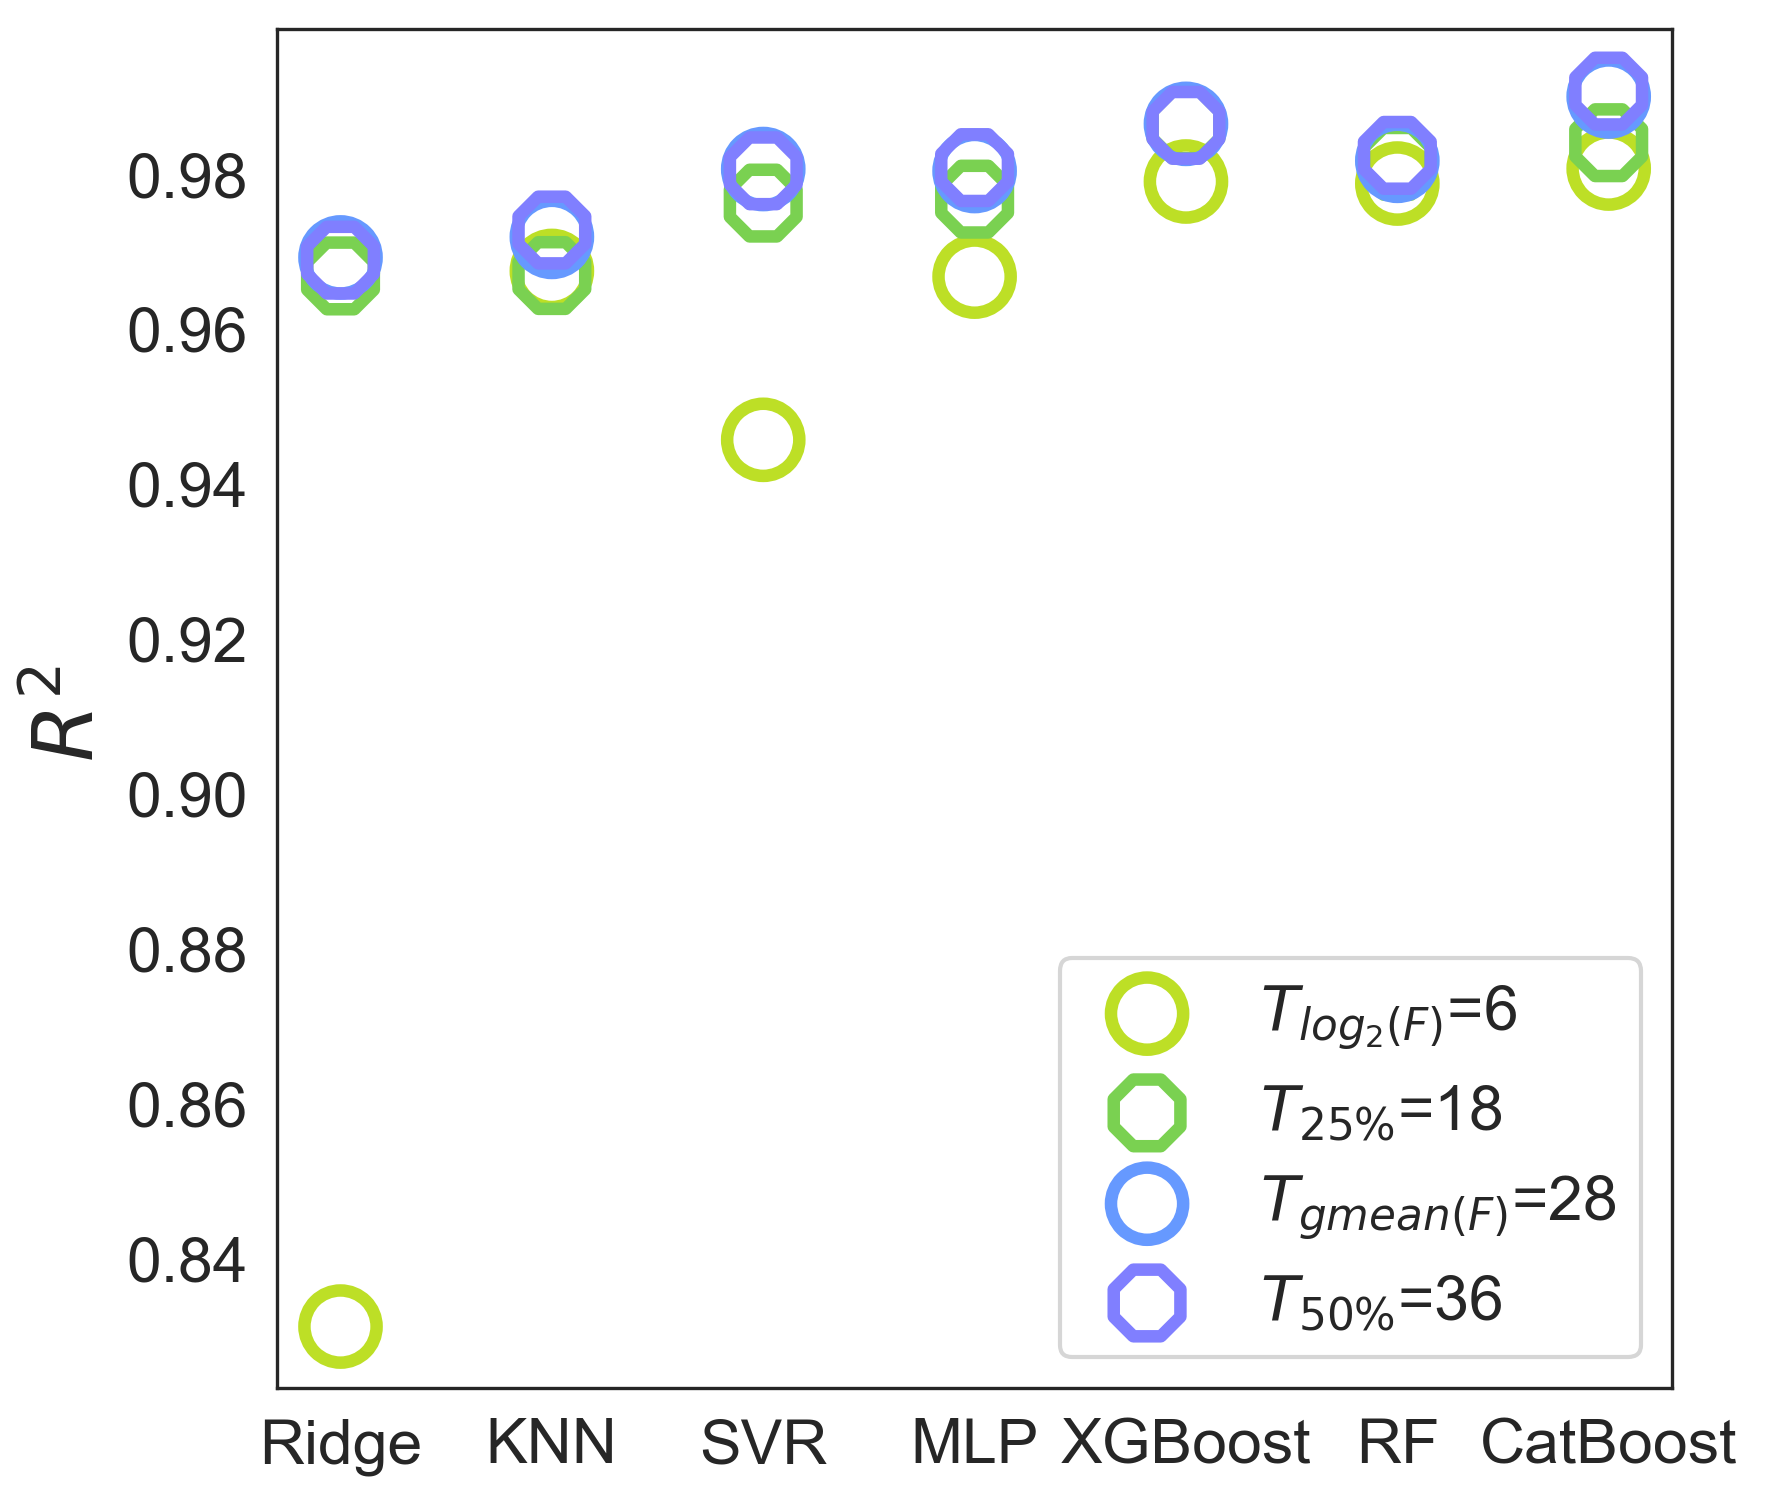

In [8]:
# 可视化

  
plt.figure(figsize=(6,6),dpi=300)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv5','thr_25_cv5','thr_geo_cv5','thr_50_cv5']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"cv5_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
    print(P[i])
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ ',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
plt.show()

### cv10_r2可视化

In [6]:
cv10_6=pd.read_csv('20221026cv10_score_sum_logn.csv')
cv10_18=pd.read_csv('20221026cv10_score_sum_25.csv')
cv10_28=pd.read_csv('20221026cv10_score_sum_geo.csv')
cv10_36=pd.read_csv('20221026cv10_score_sum_50.csv')

thr_logn_cv10=(cv10_6.iloc[2,:].values[3:]).tolist()
thr_25_cv10=(cv10_18.iloc[2,:].values[3:]).tolist()
thr_geo_cv10=(cv10_28.iloc[2,:].values[3:]).tolist()
thr_50_cv10=(cv10_36.iloc[2,:].values[3:]).tolist()

data1_sum_cv10=[]
#去掉了linear
x=['Ridge','KNN','SVR','MLP','XGBoost','RF','CatBoost']
for i  in range(len(x)):
    data1_sum_cv10+=[thr_logn_cv10[i]]+[thr_25_cv10[i]]+[thr_geo_cv10[i]]+[thr_50_cv10[i]]
data1_sum_cv10=pd.DataFrame(data1_sum_cv10,columns=['cv10_r2'])
# 模型名称重复
models_names=[]
for name in x:
    models_names+=[name]*4
models_names
thr=[]

data1_sum_cv10['models']=models_names
data1_sum_cv10['thr']=['thr_logn_cv10','thr_25_cv10','thr_geo_cv10','thr_50_cv10']*7
data1_sum_cv10

,cv10_r2,models,thr
0,0.831829,Ridge,thr_logn_cv10
1,0.967509,Ridge,thr_25_cv10
2,0.969835,Ridge,thr_geo_cv10
3,0.969286,Ridge,thr_50_cv10
4,0.967610,KNN,thr_logn_cv10
5,0.967362,KNN,thr_25_cv10
6,0.971292,KNN,thr_geo_cv10
7,0.974036,KNN,thr_50_cv10
8,0.946964,SVR,thr_logn_cv10
9,0.976321,SVR,thr_25_cv10


In [71]:
data1_sum_cv10.to_csv('20221026data1_sum_cv10.csv')

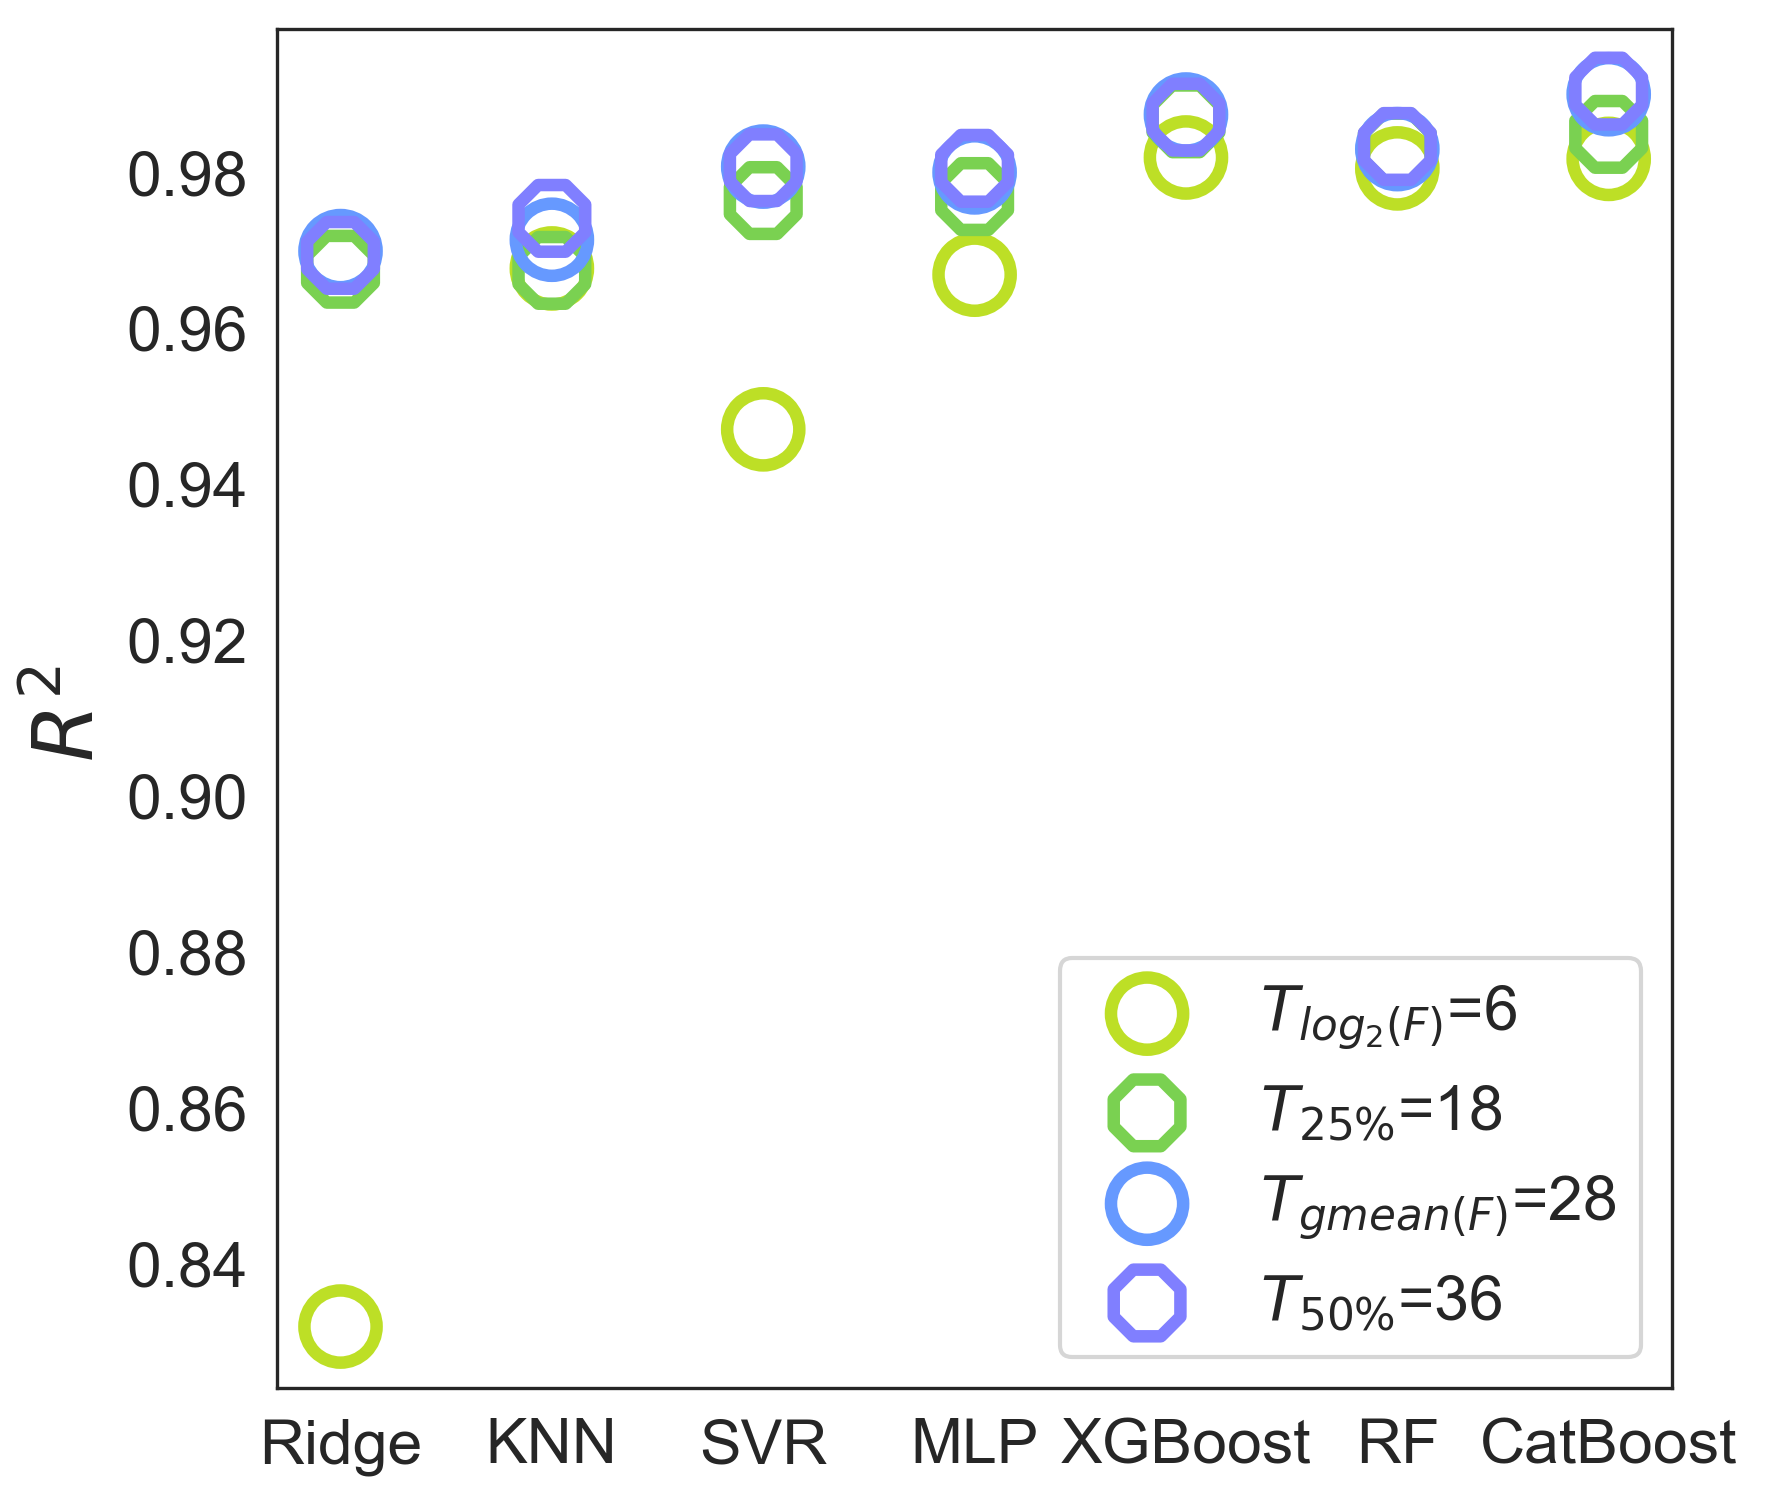

In [10]:
plt.figure(figsize=(6,6),dpi=300)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv10','thr_25_cv10','thr_geo_cv10','thr_50_cv10']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"cv10_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
    print(P[i])
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ ',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
plt.show()

In [80]:
# XGBoost
data1_sum_cv10.loc[data1_sum_cv10['thr']=='thr_logn_cv10']

,cv10_r2,models,thr
0,0.831829,Ridge,thr_logn_cv10
4,0.967610,KNN,thr_logn_cv10
8,0.946964,SVR,thr_logn_cv10
12,0.966810,MLP,thr_logn_cv10
16,0.981848,XGBoost,thr_logn_cv10
20,0.980449,RF,thr_logn_cv10
24,0.981670,CatBoost,thr_logn_cv10


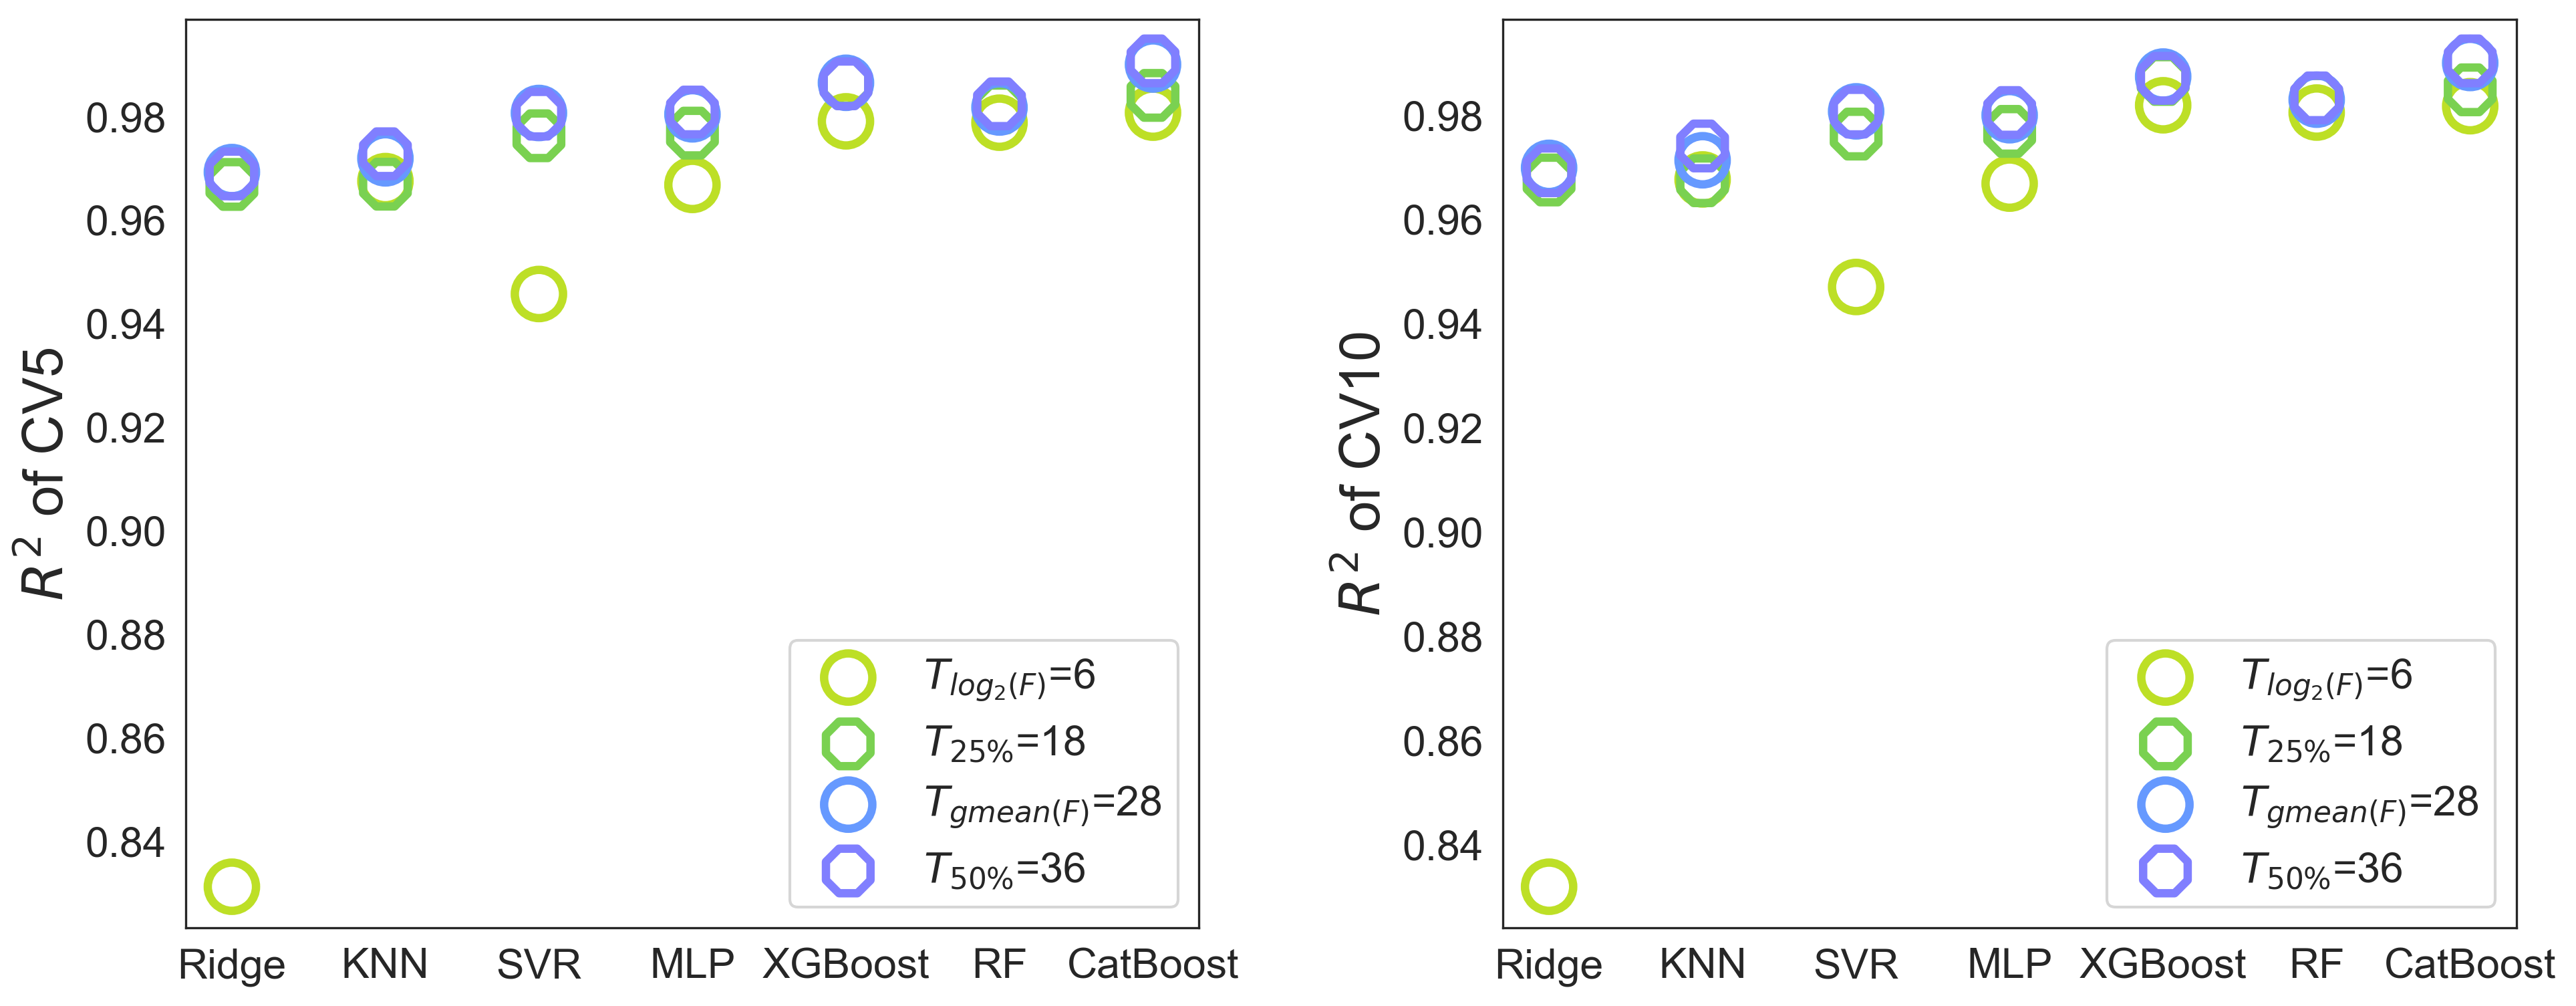

In [9]:
plt.figure(figsize=(15,6),dpi=300)
plt.subplot(1,2,1)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv5','thr_25_cv5','thr_geo_cv5','thr_50_cv5']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv5.loc[data1_sum_cv5['thr']==thr_sum[i],"cv5_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ '+'of CV5',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
#plt.show()

plt.subplot(1,2,2)
plt.rc('font',family='Times New Roman') 
sns.set_style("white") #设定整体背景风格
cm = plt.cm.get_cmap('viridis_r')
thr_sum=['thr_logn_cv10','thr_25_cv10','thr_geo_cv10','thr_50_cv10']
thr_=[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)]
#thr_=['thr_logn='+str(thr_logn),'thr_25='+str(thr_25),'thr_geo='+str(thr_geo),'thr_50='+str(thr_50)]
#colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.2),plt.cm.cool(0.3)]
#colors=['#f0c9cf','#93b5cf','#93d5dc','#83cbac']
colors=[plt.cm.viridis_r(0.1),plt.cm.viridis_r(0.2),plt.cm.cool(0.4),plt.cm.cool(0.5)]
#colors=['#44803F','#B4CF66','#FFEC5C','#FF5A33']
marker=['o','8','o','8']
P=['p1','p2','p3','p4']
for i in range(len(thr_sum)):
    P[i]=plt.scatter(data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"models"]
                    ,data1_sum_cv10.loc[data1_sum_cv10['thr']==thr_sum[i],"cv10_r2"]
                    ,s=300
                    ,marker=marker[i]
                    ,c=''
                    ,edgecolors=colors[i]
                    ,linewidths=3
                    ,label=thr_[i]
               )
#plt.xlabel('Methods',fontsize=20) #设定X轴标题大小
plt.xticks(fontsize=15)  #设定X轴刻度大小
plt.ylabel('$R^2$ '+'of CV10',fontsize=20) #设定Y轴标题大小
plt.yticks(fontsize=15)  #设定Y轴刻度大小
plt.legend(loc='lower right',fontsize=15)
#plt.legend(['p1','p2','p3','p4'],[r'$T_{{log}_2\left(F\right)}$='+str(thr_logn),r'$T_{25\%}$='+str(thr_25),r'$T_{gmean(F)}$='+str(thr_geo),r'$T_{50\%}$='+str(thr_50)],loc='lower right',fontsize=25)
#plt.show()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)


## 重复实验——集成最优结果（平衡精度和复杂度）

In [ ]:
根据可视化结果，平衡模型复杂度和精度，五折和十折均选择6个特征  模型
五折最优 6 CatBoost
十折最优 6 XGBoost  结果略有优于五折
选择十折对应的最优特征子集
['(B_x / X_x)', 'ratio_ea_bx_bond_mean', '(B_x/B_r_ion)/(X_x/X_r_ion)', '(B_ea/B_r_ion)/(X_ea/X_r_ion)', 'ratio_X_bx_bond_mean', '(B_x / X_x)/(B_r_ion + X_r_ion)']

In [83]:
#验证最优特征子集
model=XGBRegressor(random_state=0)
x_train=X_train[['(B_x / X_x)', 'ratio_ea_bx_bond_mean', '(B_x/B_r_ion)/(X_x/X_r_ion)', '(B_ea/B_r_ion)/(X_ea/X_r_ion)', 'ratio_X_bx_bond_mean', '(B_x / X_x)/(B_r_ion + X_r_ion)']]
x_test=X_test[['(B_x / X_x)', 'ratio_ea_bx_bond_mean', '(B_x/B_r_ion)/(X_x/X_r_ion)', '(B_ea/B_r_ion)/(X_ea/X_r_ion)', 'ratio_X_bx_bond_mean', '(B_x / X_x)/(B_r_ion + X_r_ion)']]
model=model.fit(x_train,y_train) 
y_pred_test= model.predict(x_test)
test_r2_=round(metrics.r2_score(y_test, y_pred_test),6)# a=[] a=计算公式 a.append(a) 会报错

cv10= KFold(n_splits=10, shuffle = True,random_state=0)
y_pred_cv10 = cross_val_predict(model,x_train,y_train, cv=cv10)
cv10_r2_=round(metrics.r2_score(y_train, y_pred_cv10),6)
cv10_r2_,test_r2_

(0.981848, 0.979366)

In [87]:
data=pd.read_csv('mix-halide-perovskite-ml-bandgap.csv')
data_=data.iloc[:,2:]
X=data_.iloc[:,1:]
y=data_.iloc[:,0]

X_logn_cut=X[['(B_x / X_x)', 'ratio_ea_bx_bond_mean', '(B_x/B_r_ion)/(X_x/X_r_ion)', '(B_ea/B_r_ion)/(X_ea/X_r_ion)', 'ratio_X_bx_bond_mean', '(B_x / X_x)/(B_r_ion + X_r_ion)']]
data_logn_cut=pd.concat([pd.DataFrame(y),X_logn_cut],axis=1)
features=data_logn_cut.columns[1:]
target=data_logn_cut.columns[0]
num_bins = round(1 + np.log2(data_logn_cut.shape[0]))
model=XGBRegressor(random_state=0)

df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_logn_cut,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2], 
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
df_result_micshap=df_result
df_result_mean_micshap=pd.DataFrame(df_result_micshap.mean()).T
df_result_mean_micshap['rs']=df_result_micshap.shape[0]
df_result_micshap

========0===========
146
50
38
26
55
66
29
14
5
4
========1===========
146
50
38
26
55
66
29
14
5
4
========2===========
146
50
38
26
55
66
29
14
5
4
========3===========
146
50
38
26
55
66
29
14
5
4
========4===========
146
50
38
26
55
66
29
14
5
4
========5===========
146
50
38
26
55
66
29
14
5
4
========6===========
146
50
38
26
55
66
29
14
5
4
========7===========
146
50
38
26
55
66
29
14
5
4
========8===========
146
50
38
26
55
66
29
14
5
4
========9===========
146
50
38
26
55
66
29
14
5
4
========10===========
146
50
38
26
55
66
29
14
5
4
========11===========
146
50
38
26
55
66
29
14
5
4
========12===========
146
50
38
26
55
66
29
14
5
4
========13===========
146
50
38
26
55
66
29
14
5
4
========14===========
146
50
38
26
55
66
29
14
5
4
========15===========
146
50
38
26
55
66
29
14
5
4
========16===========
146
50
38
26
55
66
29
14
5
4
========17===========
146
50
38
26
55
66
29
14
5
4
========18===========
146
50
38
26
55
66
29
14
5
4
========19===========
146
50
38
26
55
66


========160===========
146
50
38
26
55
66
29
14
5
4
========161===========
146
50
38
26
55
66
29
14
5
4
========162===========
146
50
38
26
55
66
29
14
5
4
========163===========
146
50
38
26
55
66
29
14
5
4
========164===========
146
50
38
26
55
66
29
14
5
4
========165===========
146
50
38
26
55
66
29
14
5
4
========166===========
146
50
38
26
55
66
29
14
5
4
========167===========
146
50
38
26
55
66
29
14
5
4
========168===========
146
50
38
26
55
66
29
14
5
4
========169===========
146
50
38
26
55
66
29
14
5
4
========170===========
146
50
38
26
55
66
29
14
5
4
========171===========
146
50
38
26
55
66
29
14
5
4
========172===========
146
50
38
26
55
66
29
14
5
4
========173===========
146
50
38
26
55
66
29
14
5
4
========174===========
146
50
38
26
55
66
29
14
5
4
========175===========
146
50
38
26
55
66
29
14
5
4
========176===========
146
50
38
26
55
66
29
14
5
4
========177===========
146
50
38
26
55
66
29
14
5
4
========178===========
146
50
38
26
55
66
29
14
5
4
========179=

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.979009,0.989490,0.278875,0.981848,0.990900,0.259331,0.979366,0.989831,0.271532
0,1,0.980657,0.990291,0.266072,0.980701,0.990319,0.265773,0.986761,0.993459,0.222988
0,2,0.976161,0.988075,0.298245,0.975935,0.987940,0.299656,0.986961,0.993720,0.212641
0,3,0.977733,0.988843,0.286806,0.980068,0.990023,0.271351,0.984350,0.992251,0.237972
0,4,0.975624,0.987740,0.300115,0.979161,0.989528,0.277493,0.983004,0.991613,0.247868
...,...,...,...,...,...,...,...,...,...,...
0,295,0.974868,0.987440,0.304411,0.978734,0.989318,0.280021,0.986618,0.993332,0.220911
0,296,0.978261,0.989106,0.284127,0.979349,0.989653,0.276926,0.982143,0.991220,0.251406
0,297,0.970031,0.984931,0.333037,0.976164,0.988024,0.297009,0.983447,0.992613,0.243804
0,298,0.975496,0.987729,0.301274,0.978618,0.989358,0.281426,0.988330,0.994234,0.204326


In [88]:
df_result_micshap

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.979009,0.989490,0.278875,0.981848,0.990900,0.259331,0.979366,0.989831,0.271532
0,1,0.980657,0.990291,0.266072,0.980701,0.990319,0.265773,0.986761,0.993459,0.222988
0,2,0.976161,0.988075,0.298245,0.975935,0.987940,0.299656,0.986961,0.993720,0.212641
0,3,0.977733,0.988843,0.286806,0.980068,0.990023,0.271351,0.984350,0.992251,0.237972
0,4,0.975624,0.987740,0.300115,0.979161,0.989528,0.277493,0.983004,0.991613,0.247868
...,...,...,...,...,...,...,...,...,...,...
0,295,0.974868,0.987440,0.304411,0.978734,0.989318,0.280021,0.986618,0.993332,0.220911
0,296,0.978261,0.989106,0.284127,0.979349,0.989653,0.276926,0.982143,0.991220,0.251406
0,297,0.970031,0.984931,0.333037,0.976164,0.988024,0.297009,0.983447,0.992613,0.243804
0,298,0.975496,0.987729,0.301274,0.978618,0.989358,0.281426,0.988330,0.994234,0.204326


In [89]:
df_result_micshap.to_csv('20221026df_result_micshap.csv')

In [90]:
df_result_mean_micshap

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.977703,0.988827,0.286378,0.979675,0.989812,0.273522,0.980844,0.990614,0.26075


### 基特征选择方法的比较

In [91]:
data=pd.read_csv('mix-halide-perovskite-ml-bandgap.csv')
data_=data.iloc[:,2:]
X=data_.iloc[:,1:]
y=data_.iloc[:,0]

num_bins = round(1 + np.log2(data_.shape[0]))# 向下取整修改为四舍五入
features=data_.columns[1:]
target=data_.columns[0]
X_train,X_test,y_train,y_test= stratifed_sample_cut(data_,target,features,groups=num_bins,train_split_ratio=0.8,random_state=0)


FN_new=6
data_mrmr=pd.concat([pd.DataFrame(y_train,columns=[target]),pd.DataFrame(X_train)],axis=1)
mRMR_features=pymrmr.mRMR(data_mrmr,'MID',FN_new)

f_score, pvalues_f = f_regression(X_train,y_train)
F_score=round(pd.DataFrame(list(zip(X_train.columns,f_score)),columns=['Features','Score_F']),6)
F_features=list(F_score.sort_values(by="Score_F",ascending=False)['Features'].values[:FN_new])

dcor_score=[]
for i in range(X_train.shape[1]):
    dcor_=dcor.distance_correlation(X_train.iloc[:,i], y_train).round(6)
    dcor_score.append(dcor_) 
Dcor_score=pd.DataFrame(list(zip(X_train.columns,dcor_score)),columns=['Features','Score_Dcor'])
Dcor_features=list(Dcor_score.sort_values(by="Score_Dcor",ascending=False)['Features'].values[:FN_new])

RF=RandomForestRegressor(random_state=0)
rfe=RFE(RF,n_features_to_select=FN_new,step=1)
selector=rfe.fit(X_train,y_train)
RFE_features=X_train.columns[rfe.get_support()]

# 基于RF 的嵌入式特征选择
RF=RandomForestRegressor(random_state=0)
RF.fit(X_train,y_train)
rffi_score=round(pd.DataFrame(list(zip(X_train.columns,RF.feature_importances_)),columns=['Features','Score_rffi']),6)
RFFI_features=list(rffi_score.sort_values(by="Score_rffi",ascending=False)['Features'].values[:FN_new])
mRMR_features,F_features,Dcor_features,RFE_features

146
50
38
26
55
66
29
14
5
4


(['(B_x/B_r_ion)',
  '(B_x - X_x)/(B_r_ion + X_r_ion)',
  '(B_x/B_r_ion)*(X_x/X_r_ion)',
  'ratio_ea_bx_bond_mean',
  'ratio_X_bx_bond_mean',
  'delta_X_bx_bond_mean'],
 ['ratio_X_bx_bond_mean',
  '(B_x / X_x)/(B_r_ion + X_r_ion)',
  '(B_x / X_x)',
  '(B_x/B_r_ion)',
  '(B_x - X_x)',
  'B_x'],
 ['(B_x / X_x)',
  'ratio_X_bx_bond_mean',
  '(B_x / X_x)/(B_r_ion + X_r_ion)',
  'B_x',
  '(B_x - X_x)',
  '(B_x/B_r_ion)/(X_x/X_r_ion)'],
 Index(['delta_ea_bx_bond_mean', 'ratio_ea_bx_bond_mean', '(B_x / X_x)',
        '(B_x - X_x)/(B_r_ion + X_r_ion)', '(B_ea - X_ea)',
        '(B_ea/B_r_ion)+(X_ea/X_r_ion)'],
       dtype='object'))

#### mRMR

In [94]:

data_mRMR=pd.concat([pd.DataFrame(y),X[mRMR_features]],axis=1)
target=data_mRMR.columns[0]
features=data_mRMR.columns[1:]
num_bins = round(1 + np.log2(data_mRMR.shape[0]))
model=XGBRegressor(random_state=0)


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_mRMR,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2],
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
df_result_mrmr=df_result   
df_result_mean_mrmr=pd.DataFrame(df_result_mrmr.mean()).T
df_result_mean_mrmr['rs']=df_result_mrmr.shape[0]
df_result_mrmr

========0===========
146
50
38
26
55
66
29
14
5
4
========1===========
146
50
38
26
55
66
29
14
5
4
========2===========
146
50
38
26
55
66
29
14
5
4
========3===========
146
50
38
26
55
66
29
14
5
4
========4===========
146
50
38
26
55
66
29
14
5
4
========5===========
146
50
38
26
55
66
29
14
5
4
========6===========
146
50
38
26
55
66
29
14
5
4
========7===========
146
50
38
26
55
66
29
14
5
4
========8===========
146
50
38
26
55
66
29
14
5
4
========9===========
146
50
38
26
55
66
29
14
5
4
========10===========
146
50
38
26
55
66
29
14
5
4
========11===========
146
50
38
26
55
66
29
14
5
4
========12===========
146
50
38
26
55
66
29
14
5
4
========13===========
146
50
38
26
55
66
29
14
5
4
========14===========
146
50
38
26
55
66
29
14
5
4
========15===========
146
50
38
26
55
66
29
14
5
4
========16===========
146
50
38
26
55
66
29
14
5
4
========17===========
146
50
38
26
55
66
29
14
5
4
========18===========
146
50
38
26
55
66
29
14
5
4
========19===========
146
50
38
26
55
66


========160===========
146
50
38
26
55
66
29
14
5
4
========161===========
146
50
38
26
55
66
29
14
5
4
========162===========
146
50
38
26
55
66
29
14
5
4
========163===========
146
50
38
26
55
66
29
14
5
4
========164===========
146
50
38
26
55
66
29
14
5
4
========165===========
146
50
38
26
55
66
29
14
5
4
========166===========
146
50
38
26
55
66
29
14
5
4
========167===========
146
50
38
26
55
66
29
14
5
4
========168===========
146
50
38
26
55
66
29
14
5
4
========169===========
146
50
38
26
55
66
29
14
5
4
========170===========
146
50
38
26
55
66
29
14
5
4
========171===========
146
50
38
26
55
66
29
14
5
4
========172===========
146
50
38
26
55
66
29
14
5
4
========173===========
146
50
38
26
55
66
29
14
5
4
========174===========
146
50
38
26
55
66
29
14
5
4
========175===========
146
50
38
26
55
66
29
14
5
4
========176===========
146
50
38
26
55
66
29
14
5
4
========177===========
146
50
38
26
55
66
29
14
5
4
========178===========
146
50
38
26
55
66
29
14
5
4
========179=

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.972548,0.986197,0.318920,0.975840,0.987857,0.299185,0.981900,0.990998,0.254308
0,1,0.978075,0.989013,0.283275,0.975418,0.987637,0.299948,0.984325,0.992417,0.242637
0,2,0.971442,0.985716,0.326436,0.973035,0.986472,0.317199,0.981802,0.990932,0.251208
0,3,0.970715,0.985340,0.328912,0.976969,0.988430,0.291685,0.979815,0.989859,0.270261
0,4,0.975531,0.987693,0.300688,0.976649,0.988258,0.293736,0.977521,0.988706,0.285060
...,...,...,...,...,...,...,...,...,...,...
0,295,0.970420,0.985101,0.330248,0.972549,0.986187,0.318143,0.985394,0.992693,0.230790
0,296,0.968119,0.984494,0.344082,0.972291,0.986167,0.320777,0.981107,0.990750,0.258601
0,297,0.969097,0.984479,0.338186,0.974802,0.987331,0.305379,0.978785,0.989742,0.276007
0,298,0.972791,0.986357,0.317465,0.975007,0.987444,0.304262,0.983433,0.991771,0.243443


In [95]:
df_result_mrmr

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.972548,0.986197,0.318920,0.975840,0.987857,0.299185,0.981900,0.990998,0.254308
0,1,0.978075,0.989013,0.283275,0.975418,0.987637,0.299948,0.984325,0.992417,0.242637
0,2,0.971442,0.985716,0.326436,0.973035,0.986472,0.317199,0.981802,0.990932,0.251208
0,3,0.970715,0.985340,0.328912,0.976969,0.988430,0.291685,0.979815,0.989859,0.270261
0,4,0.975531,0.987693,0.300688,0.976649,0.988258,0.293736,0.977521,0.988706,0.285060
...,...,...,...,...,...,...,...,...,...,...
0,295,0.970420,0.985101,0.330248,0.972549,0.986187,0.318143,0.985394,0.992693,0.230790
0,296,0.968119,0.984494,0.344082,0.972291,0.986167,0.320777,0.981107,0.990750,0.258601
0,297,0.969097,0.984479,0.338186,0.974802,0.987331,0.305379,0.978785,0.989742,0.276007
0,298,0.972791,0.986357,0.317465,0.975007,0.987444,0.304262,0.983433,0.991771,0.243443


In [96]:
df_result_mrmr.to_csv('20221026df_result_mrmr.csv')

In [97]:
df_result_mean_mrmr

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.973053,0.986481,0.314938,0.975695,0.987799,0.299161,0.977275,0.988884,0.283997


#### F检验

In [98]:
data_F=pd.concat([pd.DataFrame(y),X[F_features]],axis=1)
features=data_F.columns[1:]
target=data_F.columns[0]
num_bins = round(1 + np.log2(data_F.shape[0]))
model=XGBRegressor(random_state=0)

df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_F,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2], 
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    
df_result_f=df_result   
df_result_mean_f=pd.DataFrame(df_result_f.mean()).T
df_result_mean_f['rs']=df_result_f.shape[0]
df_result_f

========0===========
146
50
38
26
55
66
29
14
5
4
========1===========
146
50
38
26
55
66
29
14
5
4
========2===========
146
50
38
26
55
66
29
14
5
4
========3===========
146
50
38
26
55
66
29
14
5
4
========4===========
146
50
38
26
55
66
29
14
5
4
========5===========
146
50
38
26
55
66
29
14
5
4
========6===========
146
50
38
26
55
66
29
14
5
4
========7===========
146
50
38
26
55
66
29
14
5
4
========8===========
146
50
38
26
55
66
29
14
5
4
========9===========
146
50
38
26
55
66
29
14
5
4
========10===========
146
50
38
26
55
66
29
14
5
4
========11===========
146
50
38
26
55
66
29
14
5
4
========12===========
146
50
38
26
55
66
29
14
5
4
========13===========
146
50
38
26
55
66
29
14
5
4
========14===========
146
50
38
26
55
66
29
14
5
4
========15===========
146
50
38
26
55
66
29
14
5
4
========16===========
146
50
38
26
55
66
29
14
5
4
========17===========
146
50
38
26
55
66
29
14
5
4
========18===========
146
50
38
26
55
66
29
14
5
4
========19===========
146
50
38
26
55
66


========160===========
146
50
38
26
55
66
29
14
5
4
========161===========
146
50
38
26
55
66
29
14
5
4
========162===========
146
50
38
26
55
66
29
14
5
4
========163===========
146
50
38
26
55
66
29
14
5
4
========164===========
146
50
38
26
55
66
29
14
5
4
========165===========
146
50
38
26
55
66
29
14
5
4
========166===========
146
50
38
26
55
66
29
14
5
4
========167===========
146
50
38
26
55
66
29
14
5
4
========168===========
146
50
38
26
55
66
29
14
5
4
========169===========
146
50
38
26
55
66
29
14
5
4
========170===========
146
50
38
26
55
66
29
14
5
4
========171===========
146
50
38
26
55
66
29
14
5
4
========172===========
146
50
38
26
55
66
29
14
5
4
========173===========
146
50
38
26
55
66
29
14
5
4
========174===========
146
50
38
26
55
66
29
14
5
4
========175===========
146
50
38
26
55
66
29
14
5
4
========176===========
146
50
38
26
55
66
29
14
5
4
========177===========
146
50
38
26
55
66
29
14
5
4
========178===========
146
50
38
26
55
66
29
14
5
4
========179=

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.976014,0.987988,0.298107,0.976957,0.988431,0.292187,0.975900,0.987915,0.293453
0,1,0.976514,0.988210,0.293188,0.977174,0.988547,0.289037,0.981975,0.991013,0.260191
0,2,0.970130,0.984997,0.333849,0.973537,0.986683,0.314233,0.973869,0.987628,0.301027
0,3,0.972804,0.986406,0.316962,0.974912,0.987427,0.304432,0.964872,0.982337,0.356528
0,4,0.969354,0.984562,0.336509,0.974986,0.987420,0.304020,0.981895,0.991252,0.255823
...,...,...,...,...,...,...,...,...,...,...
0,295,0.968402,0.984125,0.341327,0.975105,0.987481,0.302972,0.985758,0.992857,0.227898
0,296,0.971177,0.985510,0.327162,0.975214,0.987574,0.303387,0.979827,0.990264,0.267214
0,297,0.967446,0.983599,0.347101,0.967460,0.983606,0.347029,0.978986,0.989856,0.274697
0,298,0.972054,0.986038,0.321736,0.973697,0.986856,0.312136,0.984892,0.992889,0.232478


In [99]:
df_result_f

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.976014,0.987988,0.298107,0.976957,0.988431,0.292187,0.975900,0.987915,0.293453
0,1,0.976514,0.988210,0.293188,0.977174,0.988547,0.289037,0.981975,0.991013,0.260191
0,2,0.970130,0.984997,0.333849,0.973537,0.986683,0.314233,0.973869,0.987628,0.301027
0,3,0.972804,0.986406,0.316962,0.974912,0.987427,0.304432,0.964872,0.982337,0.356528
0,4,0.969354,0.984562,0.336509,0.974986,0.987420,0.304020,0.981895,0.991252,0.255823
...,...,...,...,...,...,...,...,...,...,...
0,295,0.968402,0.984125,0.341327,0.975105,0.987481,0.302972,0.985758,0.992857,0.227898
0,296,0.971177,0.985510,0.327162,0.975214,0.987574,0.303387,0.979827,0.990264,0.267214
0,297,0.967446,0.983599,0.347101,0.967460,0.983606,0.347029,0.978986,0.989856,0.274697
0,298,0.972054,0.986038,0.321736,0.973697,0.986856,0.312136,0.984892,0.992889,0.232478


In [100]:
df_result_f.to_csv('20221026df_result_f.csv')

In [101]:
df_result_mean_f

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.971892,0.985888,0.321555,0.975073,0.987481,0.302907,0.97771,0.989118,0.281719


#### 距离相关系数

In [102]:
data_Dcor=pd.concat([pd.DataFrame(y),X[Dcor_features]],axis=1)
features=data_Dcor.columns[1:]
target=data_Dcor.columns[0]
num_bins = round(1 + np.log2(data_Dcor.shape[0]))
model=XGBRegressor(random_state=0)


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_Dcor,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2],
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    
df_result_dcor=df_result   
df_result_mean_dcor=pd.DataFrame(df_result_dcor.mean()).T
df_result_mean_dcor['rs']=df_result_dcor.shape[0]
df_result_dcor

========0===========
146
50
38
26
55
66
29
14
5
4
========1===========
146
50
38
26
55
66
29
14
5
4
========2===========
146
50
38
26
55
66
29
14
5
4
========3===========
146
50
38
26
55
66
29
14
5
4
========4===========
146
50
38
26
55
66
29
14
5
4
========5===========
146
50
38
26
55
66
29
14
5
4
========6===========
146
50
38
26
55
66
29
14
5
4
========7===========
146
50
38
26
55
66
29
14
5
4
========8===========
146
50
38
26
55
66
29
14
5
4
========9===========
146
50
38
26
55
66
29
14
5
4
========10===========
146
50
38
26
55
66
29
14
5
4
========11===========
146
50
38
26
55
66
29
14
5
4
========12===========
146
50
38
26
55
66
29
14
5
4
========13===========
146
50
38
26
55
66
29
14
5
4
========14===========
146
50
38
26
55
66
29
14
5
4
========15===========
146
50
38
26
55
66
29
14
5
4
========16===========
146
50
38
26
55
66
29
14
5
4
========17===========
146
50
38
26
55
66
29
14
5
4
========18===========
146
50
38
26
55
66
29
14
5
4
========19===========
146
50
38
26
55
66


========160===========
146
50
38
26
55
66
29
14
5
4
========161===========
146
50
38
26
55
66
29
14
5
4
========162===========
146
50
38
26
55
66
29
14
5
4
========163===========
146
50
38
26
55
66
29
14
5
4
========164===========
146
50
38
26
55
66
29
14
5
4
========165===========
146
50
38
26
55
66
29
14
5
4
========166===========
146
50
38
26
55
66
29
14
5
4
========167===========
146
50
38
26
55
66
29
14
5
4
========168===========
146
50
38
26
55
66
29
14
5
4
========169===========
146
50
38
26
55
66
29
14
5
4
========170===========
146
50
38
26
55
66
29
14
5
4
========171===========
146
50
38
26
55
66
29
14
5
4
========172===========
146
50
38
26
55
66
29
14
5
4
========173===========
146
50
38
26
55
66
29
14
5
4
========174===========
146
50
38
26
55
66
29
14
5
4
========175===========
146
50
38
26
55
66
29
14
5
4
========176===========
146
50
38
26
55
66
29
14
5
4
========177===========
146
50
38
26
55
66
29
14
5
4
========178===========
146
50
38
26
55
66
29
14
5
4
========179=

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.977329,0.988680,0.289819,0.978214,0.989054,0.284106,0.977853,0.988921,0.281312
0,1,0.975292,0.987609,0.300716,0.977973,0.988936,0.283936,0.986158,0.993129,0.228012
0,2,0.971070,0.985461,0.328555,0.972493,0.986166,0.320374,0.973275,0.987481,0.304429
0,3,0.975673,0.987843,0.299780,0.976234,0.988116,0.296304,0.955185,0.977677,0.402694
0,4,0.972234,0.986024,0.320309,0.973589,0.986707,0.312391,0.984847,0.992536,0.234045
...,...,...,...,...,...,...,...,...,...,...
0,295,0.969384,0.984600,0.335985,0.975710,0.987801,0.299269,0.985842,0.992899,0.227223
0,296,0.974326,0.987106,0.308773,0.978955,0.989461,0.279552,0.977667,0.989366,0.281154
0,297,0.968168,0.983975,0.343233,0.969303,0.984535,0.337055,0.982173,0.991343,0.253013
0,298,0.975153,0.987641,0.303375,0.976263,0.988234,0.296521,0.981741,0.991183,0.255575


In [103]:
df_result_dcor

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.977329,0.988680,0.289819,0.978214,0.989054,0.284106,0.977853,0.988921,0.281312
0,1,0.975292,0.987609,0.300716,0.977973,0.988936,0.283936,0.986158,0.993129,0.228012
0,2,0.971070,0.985461,0.328555,0.972493,0.986166,0.320374,0.973275,0.987481,0.304429
0,3,0.975673,0.987843,0.299780,0.976234,0.988116,0.296304,0.955185,0.977677,0.402694
0,4,0.972234,0.986024,0.320309,0.973589,0.986707,0.312391,0.984847,0.992536,0.234045
...,...,...,...,...,...,...,...,...,...,...
0,295,0.969384,0.984600,0.335985,0.975710,0.987801,0.299269,0.985842,0.992899,0.227223
0,296,0.974326,0.987106,0.308773,0.978955,0.989461,0.279552,0.977667,0.989366,0.281154
0,297,0.968168,0.983975,0.343233,0.969303,0.984535,0.337055,0.982173,0.991343,0.253013
0,298,0.975153,0.987641,0.303375,0.976263,0.988234,0.296521,0.981741,0.991183,0.255575


In [104]:
df_result_dcor.to_csv('20221026df_result_dcor.csv')

In [105]:
df_result_mean_dcor

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.973194,0.98655,0.313905,0.976271,0.988088,0.295438,0.978405,0.98946,0.276929


#### RF-RFE

In [106]:
data_RFE=pd.concat([pd.DataFrame(y),X[RFE_features]],axis=1)
features=data_RFE.columns[1:]
target=data_RFE.columns[0]
num_bins = round(1 + np.log2(data_RFE.shape[0]))
model=XGBRegressor(random_state=0)


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_RFE,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2], 
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    

df_result_rfrfe=df_result   
df_result_mean_rfrfe=pd.DataFrame(df_result_rfrfe.mean()).T
df_result_mean_rfrfe['rs']=df_result_rfrfe.shape[0]
df_result_rfrfe

========0===========
146
50
38
26
55
66
29
14
5
4
========1===========
146
50
38
26
55
66
29
14
5
4
========2===========
146
50
38
26
55
66
29
14
5
4
========3===========
146
50
38
26
55
66
29
14
5
4
========4===========
146
50
38
26
55
66
29
14
5
4
========5===========
146
50
38
26
55
66
29
14
5
4
========6===========
146
50
38
26
55
66
29
14
5
4
========7===========
146
50
38
26
55
66
29
14
5
4
========8===========
146
50
38
26
55
66
29
14
5
4
========9===========
146
50
38
26
55
66
29
14
5
4
========10===========
146
50
38
26
55
66
29
14
5
4
========11===========
146
50
38
26
55
66
29
14
5
4
========12===========
146
50
38
26
55
66
29
14
5
4
========13===========
146
50
38
26
55
66
29
14
5
4
========14===========
146
50
38
26
55
66
29
14
5
4
========15===========
146
50
38
26
55
66
29
14
5
4
========16===========
146
50
38
26
55
66
29
14
5
4
========17===========
146
50
38
26
55
66
29
14
5
4
========18===========
146
50
38
26
55
66
29
14
5
4
========19===========
146
50
38
26
55
66


========160===========
146
50
38
26
55
66
29
14
5
4
========161===========
146
50
38
26
55
66
29
14
5
4
========162===========
146
50
38
26
55
66
29
14
5
4
========163===========
146
50
38
26
55
66
29
14
5
4
========164===========
146
50
38
26
55
66
29
14
5
4
========165===========
146
50
38
26
55
66
29
14
5
4
========166===========
146
50
38
26
55
66
29
14
5
4
========167===========
146
50
38
26
55
66
29
14
5
4
========168===========
146
50
38
26
55
66
29
14
5
4
========169===========
146
50
38
26
55
66
29
14
5
4
========170===========
146
50
38
26
55
66
29
14
5
4
========171===========
146
50
38
26
55
66
29
14
5
4
========172===========
146
50
38
26
55
66
29
14
5
4
========173===========
146
50
38
26
55
66
29
14
5
4
========174===========
146
50
38
26
55
66
29
14
5
4
========175===========
146
50
38
26
55
66
29
14
5
4
========176===========
146
50
38
26
55
66
29
14
5
4
========177===========
146
50
38
26
55
66
29
14
5
4
========178===========
146
50
38
26
55
66
29
14
5
4
========179=

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.974501,0.987201,0.307364,0.974831,0.987353,0.305370,0.983017,0.991565,0.246336
0,1,0.973574,0.986764,0.310995,0.973987,0.986910,0.308558,0.987952,0.994044,0.212724
0,2,0.975198,0.987581,0.304210,0.975021,0.987466,0.305295,0.984874,0.992910,0.229027
0,3,0.970605,0.985197,0.329527,0.977216,0.988569,0.290116,0.980478,0.990908,0.265785
0,4,0.974762,0.987302,0.305379,0.976036,0.987949,0.297572,0.973241,0.986744,0.311014
...,...,...,...,...,...,...,...,...,...,...
0,295,0.971672,0.985742,0.323188,0.975387,0.987619,0.301247,0.987891,0.993928,0.210140
0,296,0.971849,0.986031,0.323327,0.977316,0.988631,0.290237,0.981393,0.990851,0.256630
0,297,0.961942,0.980809,0.375299,0.970290,0.985073,0.331595,0.982956,0.992004,0.247394
0,298,0.972142,0.986019,0.321230,0.975722,0.987896,0.299877,0.985828,0.993059,0.225163


In [107]:
df_result_rfrfe.to_csv('20221026df_result_rfrfe.csv')

In [108]:
df_result_mean_rfrfe

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.974747,0.987329,0.304622,0.976735,0.988327,0.292456,0.978149,0.989325,0.278252


#### RF 特征重要性

In [109]:
data_RFFI=pd.concat([pd.DataFrame(y),X[RFFI_features]],axis=1)
features=data_RFFI.columns[1:]
target=data_RFFI.columns[0]
num_bins = round(1 + np.log2(data_RFFI.shape[0]))
model=XGBRegressor(random_state=0)


df_result = pd.DataFrame()
for rs in range(0,300):
    print(f'========{rs}===========')
    X_train,X_test,y_train,y_test = stratifed_sample_cut(data_RFFI,target,features,groups=num_bins,train_split_ratio=0.8,random_state=rs)
    model=model.fit(X_train,y_train)
    y_pred_test= model.predict(X_test)
    test_r2 = round(metrics.r2_score(y_test, y_pred_test),6)
    test_r=round(np.corrcoef(y_test, y_pred_test)[0][1],6)
    test_rmse = round(np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)),6)
    
    cv5 = KFold(n_splits=5, shuffle = True,random_state=rs)
    
    y_pred_cv5 = cross_val_predict(model,X_train,y_train, cv=cv5)
    cv5_r2=round(metrics.r2_score(y_train, y_pred_cv5),6)
    cv5_r=round(np.corrcoef(y_train, y_pred_cv5)[0][1],6)
    cv5_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv5)),6)
    
    cv10= KFold(n_splits=10, shuffle = True,random_state=rs)
    y_pred_cv10 = cross_val_predict(model,X_train,y_train, cv=cv10)
    cv10_r2=round(metrics.r2_score(y_train, y_pred_cv10),6)
    cv10_r=round(np.corrcoef(y_train, y_pred_cv10)[0][1],6)
    cv10_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_cv10)),6)
    
    #loo=LeaveOneOut()
    #y_pred_loo = cross_val_predict(algo(random_state=0,verbose=False),X_train,y_train, cv=loo)
    #loo_r2=round(metrics.r2_score(y_train, y_pred_loo),6)
    #loo_rmse=round(np.sqrt(metrics.mean_squared_error(y_train, y_pred_loo)),6)
    
    dict_result = {
        'rs': [rs],  
        'cv5_r2':[cv5_r2],
        'cv5_r':[cv5_r],
        'cv5_rmse':[cv5_rmse],
        'cv10_r2':[cv10_r2],
        'cv10_r':[cv10_r],
        'cv10_rmse':[cv10_rmse],
        'test r2': [test_r2],
        'test r':[test_r],
        'test rmse': [test_rmse],
        }
    df_result=df_result.append(pd.DataFrame(dict_result))
    

df_result_rffi=df_result   
df_result_mean_rffi=pd.DataFrame(df_result_rffi.mean()).T
df_result_mean_rffi['rs']=df_result_rffi.shape[0]
df_result_rffi

========0===========
146
50
38
26
55
66
29
14
5
4
========1===========
146
50
38
26
55
66
29
14
5
4
========2===========
146
50
38
26
55
66
29
14
5
4
========3===========
146
50
38
26
55
66
29
14
5
4
========4===========
146
50
38
26
55
66
29
14
5
4
========5===========
146
50
38
26
55
66
29
14
5
4
========6===========
146
50
38
26
55
66
29
14
5
4
========7===========
146
50
38
26
55
66
29
14
5
4
========8===========
146
50
38
26
55
66
29
14
5
4
========9===========
146
50
38
26
55
66
29
14
5
4
========10===========
146
50
38
26
55
66
29
14
5
4
========11===========
146
50
38
26
55
66
29
14
5
4
========12===========
146
50
38
26
55
66
29
14
5
4
========13===========
146
50
38
26
55
66
29
14
5
4
========14===========
146
50
38
26
55
66
29
14
5
4
========15===========
146
50
38
26
55
66
29
14
5
4
========16===========
146
50
38
26
55
66
29
14
5
4
========17===========
146
50
38
26
55
66
29
14
5
4
========18===========
146
50
38
26
55
66
29
14
5
4
========19===========
146
50
38
26
55
66


========160===========
146
50
38
26
55
66
29
14
5
4
========161===========
146
50
38
26
55
66
29
14
5
4
========162===========
146
50
38
26
55
66
29
14
5
4
========163===========
146
50
38
26
55
66
29
14
5
4
========164===========
146
50
38
26
55
66
29
14
5
4
========165===========
146
50
38
26
55
66
29
14
5
4
========166===========
146
50
38
26
55
66
29
14
5
4
========167===========
146
50
38
26
55
66
29
14
5
4
========168===========
146
50
38
26
55
66
29
14
5
4
========169===========
146
50
38
26
55
66
29
14
5
4
========170===========
146
50
38
26
55
66
29
14
5
4
========171===========
146
50
38
26
55
66
29
14
5
4
========172===========
146
50
38
26
55
66
29
14
5
4
========173===========
146
50
38
26
55
66
29
14
5
4
========174===========
146
50
38
26
55
66
29
14
5
4
========175===========
146
50
38
26
55
66
29
14
5
4
========176===========
146
50
38
26
55
66
29
14
5
4
========177===========
146
50
38
26
55
66
29
14
5
4
========178===========
146
50
38
26
55
66
29
14
5
4
========179=

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,0,0.976960,0.988453,0.292171,0.977912,0.988933,0.286069,0.981904,0.991053,0.254285
0,1,0.975916,0.987908,0.296896,0.977900,0.988894,0.284406,0.986174,0.993172,0.227876
0,2,0.975178,0.987600,0.304338,0.975148,0.987555,0.304520,0.986340,0.993459,0.217648
0,3,0.971144,0.985525,0.326491,0.977732,0.988902,0.286809,0.983370,0.991821,0.245306
0,4,0.976858,0.988365,0.292420,0.977833,0.988856,0.286196,0.977631,0.989138,0.284361
...,...,...,...,...,...,...,...,...,...,...
0,295,0.972618,0.986222,0.317743,0.977947,0.988935,0.285151,0.988788,0.994380,0.202207
0,296,0.972275,0.986283,0.320868,0.978370,0.989142,0.283416,0.982558,0.991420,0.248467
0,297,0.967597,0.983738,0.346296,0.972257,0.986050,0.320428,0.982406,0.991715,0.251352
0,298,0.974718,0.987373,0.306017,0.975080,0.987579,0.303818,0.983995,0.992167,0.239279


In [110]:
df_result_rffi.to_csv('20221026df_result_rffi.csv')

In [111]:
df_result_mean_rffi

,rs,cv5_r2,cv5_r,cv5_rmse,cv10_r2,cv10_r,cv10_rmse,test r2,test r,test rmse
0,300,0.975913,0.98793,0.297449,0.977605,0.988776,0.286804,0.978711,0.989593,0.274233


### 得分汇总—5折交叉验证

In [112]:
fs_name=['MIC-SHAP','mRMR','F检验','Dcor','RF-RFE','RF']
fs_R2_5=[df_result_micshap,df_result_mrmr,df_result_f,df_result_dcor,df_result_rfrfe,df_result_rffi]
result_5_R2=pd.DataFrame()
for name,result in zip(fs_name,fs_R2_5):
    result_5_R2=pd.concat([result_5_R2,pd.DataFrame(result['cv5_r2'])],axis=1)
result_5_R2.columns=fs_name
result_5_R2

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
0,0.979009,0.972548,0.976014,0.977329,0.974501,0.976960
0,0.980657,0.978075,0.976514,0.975292,0.973574,0.975916
0,0.976161,0.971442,0.970130,0.971070,0.975198,0.975178
0,0.977733,0.970715,0.972804,0.975673,0.970605,0.971144
0,0.975624,0.975531,0.969354,0.972234,0.974762,0.976858
...,...,...,...,...,...,...
0,0.974868,0.970420,0.968402,0.969384,0.971672,0.972618
0,0.978261,0.968119,0.971177,0.974326,0.971849,0.972275
0,0.970031,0.969097,0.967446,0.968168,0.961942,0.967597
0,0.975496,0.972791,0.972054,0.975153,0.972142,0.974718


In [113]:
result_5_R2.to_csv('20221026result_5_R2.csv')

#### 配对T检验

In [115]:
#result_5_R2=pd.read_csv('cv_5_R2.csv',encoding='gbk')
def pair_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='two-sided')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_5_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.0,0.479034,0.0,0.0
F检验,,,,0.0,0.0,0.0
Dcor,,,,,0.0,0.0
RF-RFE,,,,,,0.0
RF,,,,,,


#### 单边T检验 i<j   备择假设   i对应特征选择优于j对应特征选择

In [116]:
#result_5_R2=pd.read_csv('cv_5_R2.csv',encoding='gbk')
def single_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='greater')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_5_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.0,0.479034,0.0,0.0
F检验,,,,0.0,0.0,0.0
Dcor,,,,,0.0,0.0
RF-RFE,,,,,,0.0
RF,,,,,,


### 得分汇总—10折交叉验证

In [117]:
fs_name=['MIC-SHAP','mRMR','F检验','Dcor','RF-RFE','RF']
fs_R2_10=[df_result_micshap,df_result_mrmr,df_result_f,df_result_dcor,df_result_rfrfe,df_result_rffi]
result_10_R2=pd.DataFrame()
for name,result in zip(fs_name,fs_R2_10):
    result_10_R2=pd.concat([result_10_R2,pd.DataFrame(result['cv10_r2'])],axis=1)
result_10_R2.columns=fs_name
result_10_R2

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
0,0.981848,0.975840,0.976957,0.978214,0.974831,0.977912
0,0.980701,0.975418,0.977174,0.977973,0.973987,0.977900
0,0.975935,0.973035,0.973537,0.972493,0.975021,0.975148
0,0.980068,0.976969,0.974912,0.976234,0.977216,0.977732
0,0.979161,0.976649,0.974986,0.973589,0.976036,0.977833
...,...,...,...,...,...,...
0,0.978734,0.972549,0.975105,0.975710,0.975387,0.977947
0,0.979349,0.972291,0.975214,0.978955,0.977316,0.978370
0,0.976164,0.974802,0.967460,0.969303,0.970290,0.972257
0,0.978618,0.975007,0.973697,0.976263,0.975722,0.975080


In [160]:
result_10_R2.to_csv('20221026result_10_R2.csv')

#### 配对T检验

In [118]:
def pair_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='two-sided')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_10_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.000022,0.000166,0.0,0.0
F检验,,,,0.0,0.0,0.0
Dcor,,,,,0.002182,0.0
RF-RFE,,,,,,0.0
RF,,,,,,


#### 单边T检验 i<j 备择假设 i对应特征选择优于j对应特征选择

In [120]:
def single_ttest_matrix(result_k_R2):
    columns_=result_k_R2.columns
    data = np.array(result_k_R2)
    n = len(data[0, :])
    result_p = np.zeros([n, n])#n行n列数值全部为零的矩阵
    #计算最大信息系数矩阵
    for i in range(n):
        for j in range(n):
            if i < j:# 上三角 
                result_p[i, j]=round(stats.ttest_rel(data[:, i], data[:, j],alternative='greater')[1],6)  #data[:,i] 指取data 的所有行的第0列的元素
    PM = pd.DataFrame(result_p)
    #为其加上行列名
    PM.columns=columns_
    PM.index=columns_
    return PM
P_matrix = pair_ttest_matrix(result_10_R2)
P_matrix_upper=P_matrix.where(np.triu(np.ones(P_matrix.shape),k =1).astype(np.bool))
P_matrix_upper.replace(np.NaN,'')

,MIC-SHAP,mRMR,F检验,Dcor,RF-RFE,RF
MIC-SHAP,,0.0,0.0,0.0,0.0,0.0
mRMR,,,0.000022,0.000166,0.0,0.0
F检验,,,,0.0,0.0,0.0
Dcor,,,,,0.002182,0.0
RF-RFE,,,,,,0.0
RF,,,,,,
